In [55]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [56]:
import pandas as pd
import numpy as np

# -------------------------
# 1) Load daily prices
# -------------------------
'''
raw = pd.read_csv("/content/drive/MyDrive/Prices.csv")      # path as needed
'''
raw = pd.read_csv("Prices.csv")

# drop first 2 rows ("Last Price", "PX_LAST"), fix date index, make all numeric
prices = raw.iloc[2:].copy()
prices = prices.rename(columns={"Unnamed: 0": "Date"})
prices["Date"] = pd.to_datetime(prices["Date"])
prices = prices.set_index("Date")
prices = prices.apply(pd.to_numeric, errors="coerce")   # tickers as float

# -------------------------
# 2) Daily returns, MAs, distances, vol
# -------------------------
# daily returns
ret_d = prices.pct_change()

# 50- and 200-day moving averages of price
ma50 = prices.rolling(window=50, min_periods=50).mean()
ma200 = prices.rolling(window=200, min_periods=200).mean()

# distance to MA: (Price / MA) - 1
dist50 = prices / ma50 - 1
dist200 = prices / ma200 - 1

# 30- and 60-day volatility of daily returns (simple std)
vol30 = ret_d.rolling(window=30, min_periods=30).std()
vol60 = ret_d.rolling(window=60, min_periods=60).std()

# -------------------------
# 3) Convert to monthly (month-end)
# -------------------------
price_m   = prices.resample("ME").last()
ma50_m    = ma50.resample("ME").last()
ma200_m   = ma200.resample("ME").last()
dist50_m  = dist50.resample("ME").last()
dist200_m = dist200.resample("ME").last()
vol30_m   = vol30.resample("ME").last()
vol60_m   = vol60.resample("ME").last()

# -------------------------
# 4) Monthly returns, slopes, momentum
# -------------------------
# same-month 1M return (t-1 -> t) – THIS is your return variable
ret_m = price_m.pct_change(1)

# 1, 3, 6 month momentum (backward-looking)
mom_1m = price_m.pct_change(1)
mom_3m = price_m.pct_change(3)
mom_6m = price_m.pct_change(6)

# MA slopes: monthly % change in MA
ma50_slope  = ma50_m.pct_change(1)
ma200_slope = ma200_m.pct_change(1)

# -------------------------
# 5) Wide → long panel with one row per (Date, Ticker)
# -------------------------
frames = {
    "price":       price_m,
    "return":      ret_m,        # <-- using current monthly return, no forward shift
    "mom_1m":      mom_1m,
    "mom_3m":      mom_3m,
    "mom_6m":      mom_6m,
    "ma50":        ma50_m,
    "ma200":       ma200_m,
    "dist50":      dist50_m,
    "dist200":     dist200_m,
    "vol30":       vol30_m,
    "vol60":       vol60_m,
    "ma50_slope":  ma50_slope,
    "ma200_slope": ma200_slope,
}

series_list = []
for name, dfv in frames.items():
    s = dfv.stack(dropna=False).rename(name)  # index: (Date, Ticker)
    series_list.append(s)

panel = pd.concat(series_list, axis=1).reset_index()
panel = panel.rename(columns={"level_0": "Date", "level_1": "Ticker"})

print(panel.head())
# panel is now long-format with "return" = same-month return, no forced factor lag


/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/287283205.py:10: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251

        Date          Ticker     price  return  mom_1m  mom_3m  mom_6m  ma50  \
0 2005-12-31     A UN Equity   22.4298     NaN     NaN     NaN     NaN   NaN   
1 2005-12-31  AAPL UW Equity    2.5675     NaN     NaN     NaN     NaN   NaN   
2 2005-12-31  ABBV UN Equity   33.9000     NaN     NaN     NaN     NaN   NaN   
3 2005-12-31  ABNB UW Equity  148.1300     NaN     NaN     NaN     NaN   NaN   
4 2005-12-31   ABT UN Equity   18.8662     NaN     NaN     NaN     NaN   NaN   

   ma200  dist50  dist200  vol30  vol60  ma50_slope  ma200_slope  
0    NaN     NaN      NaN    NaN    NaN         NaN          NaN  
1    NaN     NaN      NaN    NaN    NaN         NaN          NaN  
2    NaN     NaN      NaN    NaN    NaN         NaN          NaN  
3    NaN     NaN      NaN    NaN    NaN         NaN          NaN  
4    NaN     NaN      NaN    NaN    NaN         NaN          NaN  


/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/287283205.py:52: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_m = price_m.pct_change(1)
/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/287283205.py:55: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  mom_1m = price_m.pct_change(1)
/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/287283205.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or s

In [57]:
panel

,Date,Ticker,price,return,mom_1m,mom_3m,mom_6m,ma50,ma200,dist50,dist200,vol30,vol60,ma50_slope,ma200_slope
0,2005-12-31,A UN Equity,22.4298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-12-31,AAPL UW Equity,2.5675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-12-31,ABBV UN Equity,33.9000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-12-31,ABNB UW Equity,148.1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-12-31,ABT UN Equity,18.8662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120715,2025-11-30,XYZ UN Equity,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
120716,2025-11-30,YUM UN Equity,153.2100,0.108530,0.108530,0.042458,0.064402,147.5498,148.04660,0.038361,0.034877,0.017336,0.015188,0.007508,0.010555
120717,2025-11-30,ZBH UN Equity,97.5200,-0.030231,-0.030231,-0.080867,0.058045,96.8814,99.12880,0.006592,-0.016229,0.031687,0.024359,-0.045334,-0.014560
120718,2025-11-30,ZBRA UW Equity,252.7500,-0.061281,-0.061281,-0.202908,-0.127756,278.4759,291.43765,-0.092381,-0.132748,0.032046,0.027571,-0.083835,-0.044429


In [58]:
panel.describe()

,Date,price,return,mom_1m,mom_3m,mom_6m,ma50,ma200,dist50,dist200,vol30,vol60,ma50_slope,ma200_slope
count,120720,103474.000000,120217.000000,120217.000000,119211.000000,117702.000000,102468.000000,98968.000000,102468.000000,98968.000000,120217.000000,119211.000000,118737.000000,114770.000000
mean,2015-12-15 11:00:00,101.264757,0.010263,0.010263,0.030390,0.061850,100.757669,99.516129,0.010797,0.043007,0.015888,0.016253,0.007894,0.006924
min,2005-12-31 00:00:00,0.186800,-0.850634,-0.850634,-0.926679,-0.980456,0.192338,0.229164,-0.824455,-0.967358,0.000000,0.000000,-0.687725,-0.553523
25%,2010-12-23 06:00:00,30.360000,-0.026335,-0.026335,-0.034397,-0.035303,30.414950,30.683859,-0.028752,-0.039795,0.009544,0.010283,-0.012091,-0.003046
50%,2015-12-15 12:00:00,56.422550,0.000000,0.000000,0.007476,0.024475,56.346800,56.535385,0.013441,0.045997,0.014103,0.014668,0.002652,0.004609
75%,2020-12-07 18:00:00,106.890000,0.048882,0.048882,0.098870,0.155853,106.473800,105.734627,0.052126,0.125196,0.020191,0.020515,0.033433,0.020556
max,2025-11-30 00:00:00,9892.300000,2.596567,2.596567,5.045270,6.501325,9413.998000,8498.889200,1.131022,2.238824,0.494913,0.350544,1.254205,0.418803
std,NaN,231.126797,0.085135,0.085135,0.149109,0.224747,228.972390,221.854254,0.077039,0.155853,0.012811,0.012425,0.050681,0.026379


In [59]:
# export panel to CSV
panel.to_csv("final_panel.csv", index=False)


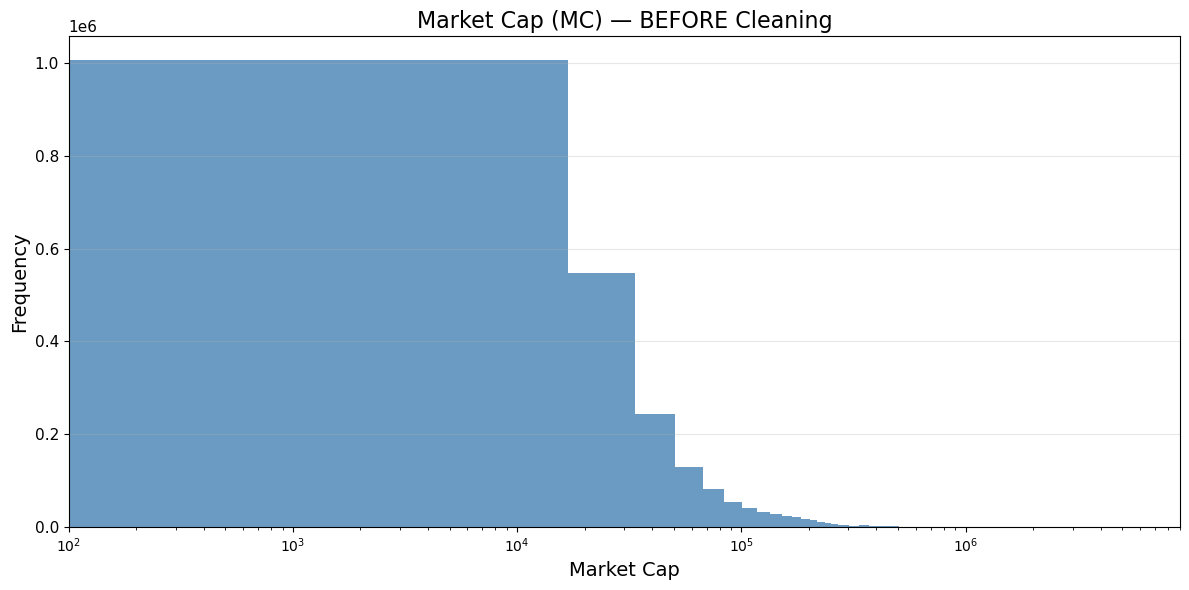

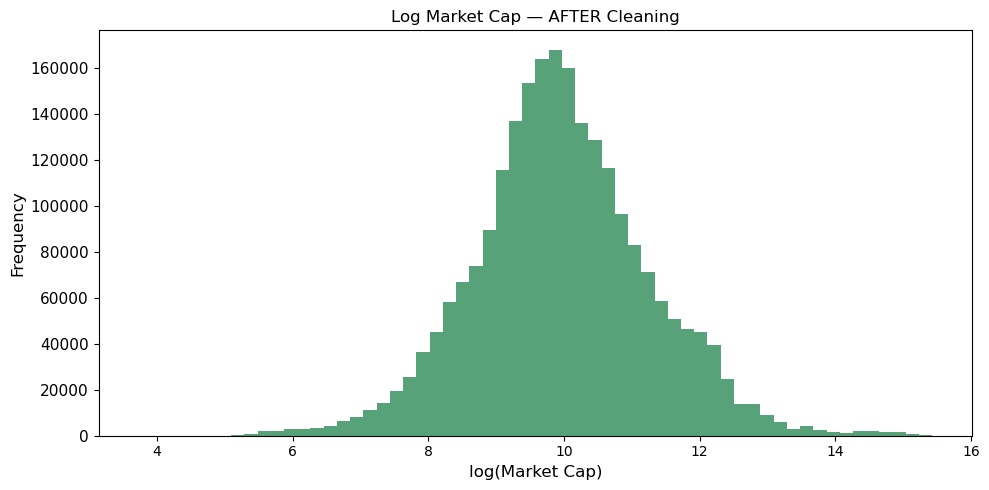

        Date          Ticker   log_mcap
0 2005-12-31     A UN Equity   9.727833
1 2005-12-31  AAPL UW Equity  11.011829
2 2005-12-31  ABBV UN Equity  10.887542
3 2005-12-31  ABNB UW Equity  11.410103
4 2005-12-31   ABT UN Equity  11.021329


/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/2581993712.py:83: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 1) Load raw market cap file
# -------------------------
'''
raw_mc = pd.read_csv("/content/drive/MyDrive/mc.csv")
'''
raw_mc = pd.read_csv("mc.csv", low_memory=False)

# Drop first 2 junk rows EXACTLY like Prices.csv
mc = raw_mc.iloc[2:].copy()

# Rename date column EXACTLY like Prices.csv
mc = mc.rename(columns={"Unnamed: 0": "Date"})

# Convert date column to datetime (coerce bad values) and drop them
mc["Date"] = pd.to_datetime(mc["Date"], errors="coerce")
mc = mc.dropna(subset=["Date"])

# Set index + sort
mc = mc.set_index("Date").sort_index()

# Convert all tickers to numeric
mc = mc.apply(pd.to_numeric, errors="coerce")

# ===========================================================
# ⭐ HISTOGRAM 1 — BEFORE CLEANING (RAW MARKET CAP)
# ===========================================================
plt.figure(figsize=(12,6))

plt.hist(
    mc.values.flatten(), 
    bins=300,                   # more bins = smoother shape
    color="steelblue", 
    alpha=0.8
)

plt.title("Market Cap (MC) — BEFORE Cleaning", fontsize=16)
plt.xlabel("Market Cap", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.xscale("log")               # keep log scale because raw MC is explosive
plt.xlim(left=1e2)              # give breathing room on left
plt.ylim(top=None)              # let matplotlib choose best top
plt.grid(axis='y', alpha=0.3)   # light grid improves readability

plt.tight_layout()
plt.show()
# ===========================================================

# -------------------------
# 2) Convert market cap → LOG market cap
# -------------------------
log_mc = np.log(mc)


# ===========================================================
# HISTOGRAM 2 — AFTER CLEANING (LOG MARKET CAP)
# ===========================================================
plt.figure(figsize=(10,5))
plt.hist(log_mc.values.flatten(), bins=60, color="seagreen", alpha=0.8)
plt.title("Log Market Cap — AFTER Cleaning")
plt.xlabel("log(Market Cap)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
# ===========================================================


# -------------------------
# 3) Convert to monthly using month-end ("ME")
# -------------------------
log_mc_m = log_mc.resample("ME").last()

# -------------------------
# 4) Wide → long panel
# -------------------------
log_mc_long = (
    log_mc_m
    .stack(dropna=False)
    .reset_index()
    .rename(columns={0: "log_mcap", "level_1": "Ticker"})
)

print(log_mc_long.head())


In [147]:
# ---------- BETA: DAILY → MONTHLY LONG PANEL ----------
'''
raw_beta = pd.read_csv("/content/drive/MyDrive/beta.csv")
'''
raw_beta = pd.read_csv("beta.csv")

beta = raw_beta.iloc[2:].copy()
beta = beta.rename(columns={"Unnamed: 0": "Date"})
beta["Date"] = pd.to_datetime(beta["Date"])
beta = beta.set_index("Date").sort_index()

beta = beta.apply(pd.to_numeric, errors="coerce")

# daily → month-end
beta_m = beta.resample("ME").last()

# wide → long, keep NaNs
beta_long = (
    beta_m
      .stack(dropna=False)
      .reset_index()
      .rename(columns={"level_1": "Ticker", 0: "beta"})
)

print(beta_long.head())
# Columns: Date | Ticker | beta


/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/3146652022.py:5: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251

        Date          Ticker    beta
0 2005-12-31     A UN Equity  1.5364
1 2005-12-31  AAPL UW Equity  1.5849
2 2005-12-31  ABBV UN Equity  0.6868
3 2005-12-31  ABNB UW Equity  1.3339
4 2005-12-31   ABT UN Equity  0.6867


/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/3146652022.py:20: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


In [62]:
import pandas as pd
import numpy as np

# ---------- ROE: QUARTERLY → MONTHLY LONG PANEL ----------
'''
raw_roe = pd.read_csv("/content/drive/MyDrive/roe.csv")
'''
raw_roe = pd.read_csv("roe.csv")

# same style as prices: first 2 rows are junk, date in 'Unnamed: 0'
roe = raw_roe.iloc[2:].copy()
roe = roe.rename(columns={"Unnamed: 0": "Date"})
roe["Date"] = pd.to_datetime(roe["Date"])
roe = roe.set_index("Date").sort_index()

# make all tickers numeric
roe = roe.apply(pd.to_numeric, errors="coerce")

# if there are duplicate quarterly dates, collapse them (take last)
roe = roe.groupby(level=0).last()

# quarterly → monthly, forward-fill ROE
# use "M" for month-end, same as you used for prices
roe_m = roe.resample("ME").ffill()

# wide → long, DO NOT DROP NAs
roe_long = (
    roe_m
      .stack(dropna=False)   # keep NaNs so merge is easy later
      .reset_index()
      .rename(columns={"level_1": "Ticker", 0: "roe"})
)

print(roe_long.head())
# Columns: Date | Ticker | roe


        Date          Ticker      roe
0 2006-01-31     A UN Equity  76.4780
1 2006-01-31  AAPL UW Equity  22.6112
2 2006-01-31  ABBV UN Equity      NaN
3 2006-01-31  ABNB UW Equity      NaN
4 2006-01-31   ABT UN Equity  23.4651


/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/2158705573.py:29: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)   # keep NaNs so merge is easy later


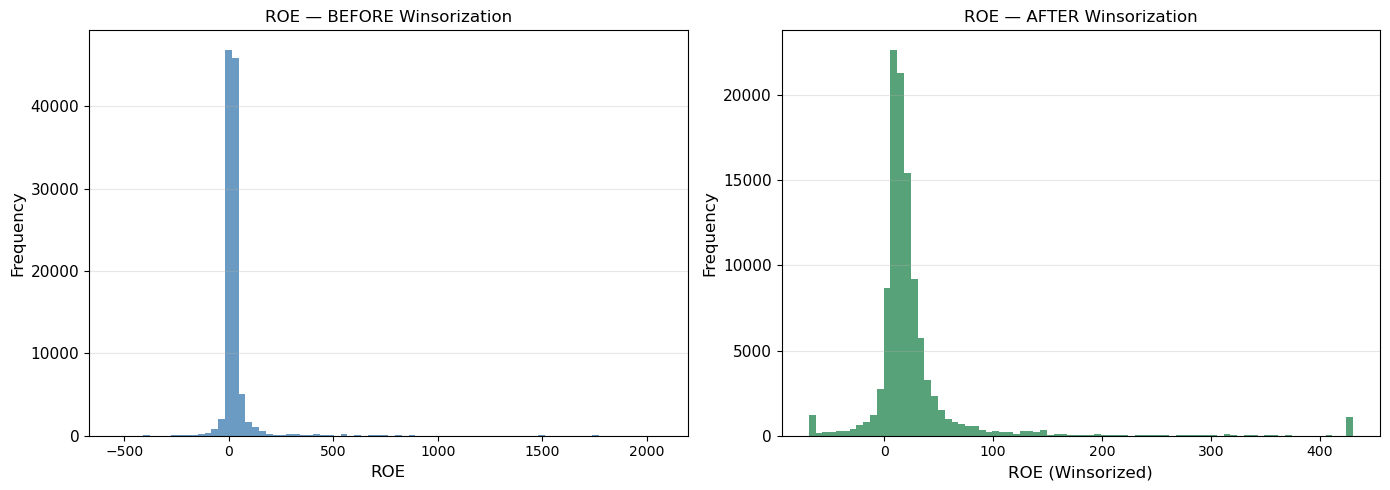

In [149]:
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 1) Extract raw ROE values (flatten, but KEEP NaNs removed)
# -----------------------------------------------------------
raw_roe_vals = roe_long["roe"].values
raw_roe_vals = raw_roe_vals[~np.isnan(raw_roe_vals)]  # drop NaNs

# -----------------------------------------------------------
# 2) Winsorization (1% and 99% caps)
# -----------------------------------------------------------
lower = np.nanpercentile(raw_roe_vals, 1)
upper = np.nanpercentile(raw_roe_vals, 99)

roe_winz = np.clip(raw_roe_vals, lower, upper)

# -----------------------------------------------------------
# 3) PLOT — Before & After Winsorization (Side by Side)
# -----------------------------------------------------------
plt.figure(figsize=(14,5))

# --- BEFORE ---
plt.subplot(1,2,1)
plt.hist(raw_roe_vals, bins=80, color="steelblue", alpha=0.8)
plt.title("ROE — BEFORE Winsorization")
plt.xlabel("ROE")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)

# --- AFTER ---
plt.subplot(1,2,2)
plt.hist(roe_winz, bins=80, color="seagreen", alpha=0.8)
plt.title("ROE — AFTER Winsorization")
plt.xlabel("ROE (Winsorized)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


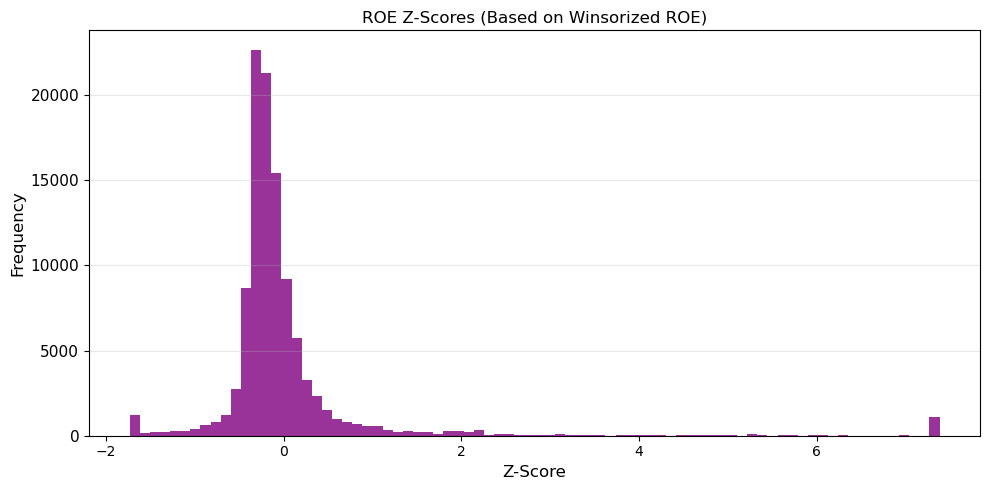

In [ ]:
# -----------------------------------------------------------
# 4) Compute ROE Z-scores (using winsorized ROE values)
# -----------------------------------------------------------

roe_mean = np.mean(roe_winz)
roe_std = np.std(roe_winz)

roe_z = (roe_winz - roe_mean) / roe_std

# -----------------------------------------------------------
# 5) Plot histogram of ROE Z-scores
# -----------------------------------------------------------

plt.figure(figsize=(10,5))
plt.hist(roe_z, bins=80, color="purple", alpha=0.8)

plt.title("ROE Z-Scores")
plt.xlabel("Z-Score")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [63]:
roe_long

,Date,Ticker,roe
0,2006-01-31,A UN Equity,76.4780
1,2006-01-31,AAPL UW Equity,22.6112
2,2006-01-31,ABBV UN Equity,NaN
3,2006-01-31,ABNB UW Equity,NaN
4,2006-01-31,ABT UN Equity,23.4651
...,...,...,...
119709,2025-10-31,XYZ UN Equity,14.7821
119710,2025-10-31,YUM UN Equity,139.0231
119711,2025-10-31,ZBH UN Equity,6.4071
119712,2025-10-31,ZBRA UW Equity,14.2857


In [64]:
import pandas as pd
import numpy as np

# ---------- D/E: QUARTERLY → MONTHLY LONG PANEL ----------

'''
raw_de = pd.read_csv("/content/drive/MyDrive/de.csv")
'''
raw_de = pd.read_csv("de.csv")

# same style as prices: first 2 rows are junk, date in 'Unnamed: 0'
de = raw_de.iloc[2:].copy()
de = de.rename(columns={"Unnamed: 0": "Date"})
de["Date"] = pd.to_datetime(de["Date"])
de = de.set_index("Date").sort_index()

# make all tickers numeric
de = de.apply(pd.to_numeric, errors="coerce")

# if there are duplicate quarterly dates, collapse them (take last)
de = de.groupby(level=0).last()

# quarterly → monthly, forward-fill D/E
# using "ME" month-end to match your other code
de_m = de.resample("ME").ffill()

# wide → long, DO NOT DROP NAs
de_long = (
    de_m
      .stack(dropna=False)   # keep NaNs so merge is easy later
      .reset_index()
      .rename(columns={"level_1": "Ticker", 0: "de"})
)

print(de_long.head())
# Columns: Date | Ticker | de


        Date          Ticker       de
0 2006-01-31     A UN Equity  35.8680
1 2006-01-31  AAPL UW Equity   0.0000
2 2006-01-31  ABBV UN Equity      NaN
3 2006-01-31  ABNB UW Equity      NaN
4 2006-01-31   ABT UN Equity  46.0173


/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/1960695936.py:30: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)   # keep NaNs so merge is easy later


In [65]:
import pandas as pd
import numpy as np

# ---------- OPERATING MARGIN (OM): QUARTERLY → MONTHLY LONG PANEL ----------

'''
raw_om = pd.read_csv("/content/drive/MyDrive/om.csv")
'''
raw_om = pd.read_csv("om.csv")


# same style as prices: first 2 rows are junk, date in 'Unnamed: 0'
om = raw_om.iloc[2:].copy()
om = om.rename(columns={"Unnamed: 0": "Date"})
om["Date"] = pd.to_datetime(om["Date"])
om = om.set_index("Date").sort_index()

# make all tickers numeric
om = om.apply(pd.to_numeric, errors="coerce")

# if quarterly dates are duplicated (rare but possible), take last
om = om.groupby(level=0).last()

# quarterly → monthly, forward-fill values
om_m = om.resample("ME").ffill()

# wide → long, DO NOT DROP missing values (needed for merging)
om_long = (
    om_m
      .stack(dropna=False)
      .reset_index()
      .rename(columns={"level_1": "Ticker", 0: "op_margin"})
)

print(om_long.head())
# Columns: Date | Ticker | op_margin


        Date          Ticker  op_margin
0 2006-01-31     A UN Equity     4.5905
1 2006-01-31  AAPL UW Equity    12.2915
2 2006-01-31  ABBV UN Equity        NaN
3 2006-01-31  ABNB UW Equity        NaN
4 2006-01-31   ABT UN Equity    21.6467


/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/3643302425.py:30: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


In [66]:
import pandas as pd
import numpy as np

# ---------- NPM: QUARTERLY → MONTHLY LONG PANEL ----------

'''
raw_npm = pd.read_csv("/content/drive/MyDrive/npm.csv")
'''
raw_npm = pd.read_csv("npm.csv")

# remove junk header rows, rename date column
npm = raw_npm.iloc[2:].copy()
npm = npm.rename(columns={"Unnamed: 0": "Date"})
npm["Date"] = pd.to_datetime(npm["Date"])
npm = npm.set_index("Date").sort_index()

# convert all factor columns to numeric
npm = npm.apply(pd.to_numeric, errors="coerce")

# collapse duplicate quarterly dates (take last entry)
npm = npm.groupby(level=0).last()

# quarterly → monthly (month-end), forward-fill values
npm_m = npm.resample("ME").ffill()

# wide → long, KEEP NaNs so merging with other panels is perfect
npm_long = (
    npm_m
      .stack(dropna=False)
      .reset_index()
      .rename(columns={"level_1": "Ticker", 0: "npm"})
)

print(npm_long.head())
# final columns: Date | Ticker | npm


        Date          Ticker      npm
0 2006-01-31     A UN Equity  65.5172
1 2006-01-31  AAPL UW Equity   9.8950
2 2006-01-31  ABBV UN Equity      NaN
3 2006-01-31  ABNB UW Equity      NaN
4 2006-01-31   ABT UN Equity  15.0958


/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/2591337323.py:29: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


In [67]:
import pandas as pd
import numpy as np

# ---------- EARNINGS YIELD (1/PE): QUARTERLY → MONTHLY LONG PANEL ----------

'''
raw_pe = pd.read_csv("/content/drive/MyDrive/pe.csv")
'''
raw_pe = pd.read_csv("pe.csv")

# same template as other fundamental datasets
pe = raw_pe.iloc[2:].copy()
pe = pe.rename(columns={"Unnamed: 0": "Date"})
pe["Date"] = pd.to_datetime(pe["Date"])
pe = pe.set_index("Date").sort_index()

# convert all ticker columns to numeric
pe = pe.apply(pd.to_numeric, errors="coerce")

# collapse duplicate quarterly dates (just in case)
pe = pe.groupby(level=0).last()

# ---- Convert PE → Earnings Yield ----
# Avoid division errors: if PE <= 0 or NaN → earnings yield stays NaN
earn_yield = 1 / pe.replace(0, np.nan)

# quarterly → monthly via forward-fill
ey_m = earn_yield.resample("ME").ffill()

# wide → long format, *keep NaNs*
ey_long = (
    ey_m
      .stack(dropna=False)
      .reset_index()
      .rename(columns={"level_1": "Ticker", 0: "earn_yield"})
)

print(ey_long.head())


        Date          Ticker  earn_yield
0 2005-12-31     A UN Equity    0.045208
1 2005-12-31  AAPL UW Equity    0.025873
2 2005-12-31  ABBV UN Equity         NaN
3 2005-12-31  ABNB UW Equity         NaN
4 2005-12-31   ABT UN Equity    0.132512


/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/3706862423.py:33: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


In [68]:
import pandas as pd
import numpy as np

# ---------- PB → B/P: QUARTERLY → MONTHLY → LONG PANEL ----------

'''
raw_pb = pd.read_csv("/content/drive/MyDrive/pb.csv")
'''
raw_pb = pd.read_csv("pb.csv")

pb = raw_pb.iloc[2:].copy()
pb = pb.rename(columns={"Unnamed: 0": "Date"})
pb["Date"] = pd.to_datetime(pb["Date"])
pb = pb.set_index("Date").sort_index()

# numeric PB
pb = pb.apply(pd.to_numeric, errors="coerce")

# collapse duplicate quarter rows
pb = pb.groupby(level=0).last()

# convert PB → book yield (B/P)
bp = 1 / pb

# quarterly → monthly
bp_m = bp.resample("ME").ffill()

# long format
bp_long = (
    bp_m
        .stack(dropna=False)
        .reset_index()
        .rename(columns={"level_1": "Ticker", 0: "bp"})
)

print(bp_long.head())


        Date          Ticker        bp
0 2005-12-31     A UN Equity  0.361716
1 2005-12-31  AAPL UW Equity  0.137849
2 2005-12-31  ABBV UN Equity       NaN
3 2005-12-31  ABNB UW Equity       NaN
4 2005-12-31   ABT UN Equity  0.496401


/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/3700663035.py:31: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


In [69]:
import pandas as pd
import numpy as np

# ---------- REVENUE/SHARE GROWTH: QUARTERLY → MONTHLY LONG PANEL ----------

'''
raw_rev = pd.read_csv("/content/drive/MyDrive/rev.csv")
'''
raw_rev = pd.read_csv("rev.csv")

# same style as prices: first 2 rows are junk, date in 'Unnamed: 0'
rev = raw_rev.iloc[2:].copy()
rev = rev.rename(columns={"Unnamed: 0": "Date"})
rev["Date"] = pd.to_datetime(rev["Date"])
rev = rev.set_index("Date").sort_index()

# make all tickers numeric
rev = rev.apply(pd.to_numeric, errors="coerce")

# if there are duplicate quarterly dates, collapse them (take last)
rev = rev.groupby(level=0).last()

# 1) QUARTER-ON-QUARTER GROWTH (QoQ), NOT year-over-year
# use fill_method=None to silence the pct_change warning
rev_growth_q = rev.pct_change(1, fill_method=None)

# 2) QUARTERLY → MONTH-END, forward-fill growth between quarter dates
rev_growth_m = rev_growth_q.resample("ME").ffill()

# 3) WIDE → LONG, DO NOT DROP NAs
rev_growth_long = (
    rev_growth_m
      .stack(dropna=False)        # index: (Date, Ticker)
      .reset_index()
      .rename(columns={"level_1": "Ticker", 0: "revps_growth"})
)

print(rev_growth_long.head())
# Columns: Date | Ticker | revps_growth


        Date          Ticker  revps_growth
0 2006-01-31     A UN Equity           NaN
1 2006-01-31  AAPL UW Equity           NaN
2 2006-01-31  ABBV UN Equity           NaN
3 2006-01-31  ABNB UW Equity           NaN
4 2006-01-31   ABT UN Equity           NaN


/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/2213596338.py:33: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)        # index: (Date, Ticker)


In [70]:
from pandas.tseries.offsets import MonthEnd

dfs = [
    panel,
    log_mc_long, beta_long,
    roe_long, de_long, om_long, npm_long,
    ey_long, bp_long, rev_growth_long
]

for df in dfs:
    df["Date"] = pd.to_datetime(df["Date"])
    df["Date"] = df["Date"] + MonthEnd(0)


In [150]:
# start from price-based panel
dataset = panel.copy()

# merge in each factor (all left joins on Date + Ticker)
dataset = dataset.merge(log_mc_long,      on=["Date", "Ticker"], how="left")
dataset = dataset.merge(beta_long,        on=["Date", "Ticker"], how="left")
dataset = dataset.merge(roe_long,         on=["Date", "Ticker"], how="left")
dataset = dataset.merge(de_long,          on=["Date", "Ticker"], how="left")
dataset = dataset.merge(om_long,          on=["Date", "Ticker"], how="left")   # op_margin
dataset = dataset.merge(npm_long,         on=["Date", "Ticker"], how="left")
dataset = dataset.merge(ey_long,          on=["Date", "Ticker"], how="left")   # earnings yield
dataset = dataset.merge(bp_long,          on=["Date", "Ticker"], how="left")   # book-to-price
dataset = dataset.merge(rev_growth_long,on=["Date", "Ticker"], how="left")

print(dataset.head())
print(dataset.columns)


        Date          Ticker     price  return  mom_1m  mom_3m  mom_6m  ma50  \
0 2005-12-31     A UN Equity   22.4298     NaN     NaN     NaN     NaN   NaN   
1 2005-12-31  AAPL UW Equity    2.5675     NaN     NaN     NaN     NaN   NaN   
2 2005-12-31  ABBV UN Equity   33.9000     NaN     NaN     NaN     NaN   NaN   
3 2005-12-31  ABNB UW Equity  148.1300     NaN     NaN     NaN     NaN   NaN   
4 2005-12-31   ABT UN Equity   18.8662     NaN     NaN     NaN     NaN   NaN   

   ma200  dist50  ...  ma200_slope   log_mcap    beta  roe  de  op_margin  \
0    NaN     NaN  ...          NaN   9.727833  1.5364  NaN NaN        NaN   
1    NaN     NaN  ...          NaN  11.011829  1.5849  NaN NaN        NaN   
2    NaN     NaN  ...          NaN  10.887542  0.6868  NaN NaN        NaN   
3    NaN     NaN  ...          NaN  11.410103  1.3339  NaN NaN        NaN   
4    NaN     NaN  ...          NaN  11.021329  0.6867  NaN NaN        NaN   

   npm  earn_yield        bp  revps_growth  
0  NaN    0

In [72]:
dataset

,Date,Ticker,price,return,mom_1m,mom_3m,mom_6m,ma50,ma200,dist50,...,ma200_slope,log_mcap,beta,roe,de,op_margin,npm,earn_yield,bp,revps_growth
0,2005-12-31,A UN Equity,22.4298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9.727833,1.5364,NaN,NaN,NaN,NaN,0.045208,0.361716,NaN
1,2005-12-31,AAPL UW Equity,2.5675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11.011829,1.5849,NaN,NaN,NaN,NaN,0.025873,0.137849,NaN
2,2005-12-31,ABBV UN Equity,33.9000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.887542,0.6868,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-12-31,ABNB UW Equity,148.1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11.410103,1.3339,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-12-31,ABT UN Equity,18.8662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11.021329,0.6867,NaN,NaN,NaN,NaN,0.132512,0.496401,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120715,2025-11-30,XYZ UN Equity,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120716,2025-11-30,YUM UN Equity,153.2100,0.108530,0.108530,0.042458,0.064402,147.5498,148.04660,0.038361,...,0.010555,10.658181,0.3944,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120717,2025-11-30,ZBH UN Equity,97.5200,-0.030231,-0.030231,-0.080867,0.058045,96.8814,99.12880,0.006592,...,-0.014560,9.869241,0.3696,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120718,2025-11-30,ZBRA UW Equity,252.7500,-0.061281,-0.061281,-0.202908,-0.127756,278.4759,291.43765,-0.092381,...,-0.044429,9.457542,1.6057,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
dataset = dataset.drop(columns=["price","ma50","ma200"])

In [74]:
dataset.describe()

,Date,return,mom_1m,mom_3m,mom_6m,dist50,dist200,vol30,vol60,ma50_slope,ma200_slope,log_mcap,beta,roe,de,op_margin,npm,earn_yield,bp,revps_growth
count,120720,120217.000000,120217.000000,119211.000000,117702.000000,102468.000000,98968.000000,120217.000000,119211.000000,118737.000000,114770.000000,104546.000000,103467.000000,106829.000000,108741.000000,108827.000000,108854.000000,100256.000000,101676.000000,106219.000000
mean,2015-12-15 11:00:00,0.010263,0.010263,0.030390,0.061850,0.010797,0.043007,0.015888,0.016253,0.007894,0.006924,9.919670,1.018663,28.394729,318.740626,13.997279,8.179074,0.057091,0.405565,0.018445
min,2005-12-31 00:00:00,-0.850634,-0.850634,-0.926679,-0.980456,-0.824455,-0.967358,0.000000,0.000000,-0.687725,-0.553523,4.087243,-5.917100,-538.349300,0.000000,-9510.006400,-14870.698100,0.000011,0.000066,-17.771605
25%,2010-12-23 06:00:00,-0.026335,-0.026335,-0.034397,-0.035303,-0.028752,-0.039795,0.009544,0.010283,-0.012091,-0.003046,9.129429,0.777700,8.860500,33.047300,9.211900,5.430200,0.034622,0.160716,0.000000
50%,2015-12-15 12:00:00,0.000000,0.000000,0.007476,0.024475,0.013441,0.045997,0.014103,0.014668,0.002652,0.004609,9.871553,0.997900,15.763000,71.536900,15.765800,10.356500,0.050665,0.316036,0.018075
75%,2020-12-07 18:00:00,0.048882,0.048882,0.098870,0.155853,0.052126,0.125196,0.020191,0.020515,0.033433,0.020556,10.693016,1.230200,26.470600,134.581100,24.150600,17.438300,0.071249,0.536164,0.036697
max,2025-11-30 00:00:00,2.596567,2.596567,5.045270,6.501325,1.131022,2.238824,0.494913,0.350544,1.254205,0.418803,15.408922,143.632800,2065.267200,557936.047200,100.924200,179.899800,1.246572,20.283976,5.308215
std,NaN,0.085135,0.085135,0.149109,0.224747,0.077039,0.155853,0.012811,0.012425,0.050681,0.026379,1.295546,0.578219,91.403991,5061.265513,95.320077,125.489597,0.038521,0.409930,0.129822


In [75]:
dataset.columns

Index(['Date', 'Ticker', 'return', 'mom_1m', 'mom_3m', 'mom_6m', 'dist50',
       'dist200', 'vol30', 'vol60', 'ma50_slope', 'ma200_slope', 'log_mcap',
       'beta', 'roe', 'de', 'op_margin', 'npm', 'earn_yield', 'bp',
       'revps_growth'],
      dtype='object')

In [76]:
# =====================================
# STEP 1 — LAG FIRST
# =====================================

# technical factors (lag 1 month)
tech_cols = [
    "mom_1m", "mom_3m", "mom_6m",
    "dist50", "dist200",
    "vol30", "vol60",
    "ma50_slope", "ma200_slope",
    "log_mcap", "beta"
]

# fundamental factors (lag 2 months)
fund_cols = [
    "roe", "de", "op_margin", "npm",
    "earn_yield", "bp", "revps_growth"
]

# --- lag technicals by 1 month ---
for col in tech_cols:
    dataset[col + "_l1"] = dataset.groupby("Ticker")[col].shift(1)

# --- lag fundamentals by 2 months ---
for col in fund_cols:
    dataset[col + "_l2"] = dataset.groupby("Ticker")[col].shift(2)

# drop original unlagged columns
dataset = dataset.drop(columns = tech_cols + fund_cols)


In [77]:
dataset

,Date,Ticker,return,mom_1m_l1,mom_3m_l1,mom_6m_l1,dist50_l1,dist200_l1,vol30_l1,vol60_l1,...,ma200_slope_l1,log_mcap_l1,beta_l1,roe_l2,de_l2,op_margin_l2,npm_l2,earn_yield_l2,bp_l2,revps_growth_l2
0,2005-12-31,A UN Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-12-31,AAPL UW Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-12-31,ABBV UN Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-12-31,ABNB UW Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-12-31,ABT UN Equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120715,2025-11-30,XYZ UN Equity,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,...,0.000000,NaN,NaN,14.2700,23.1022,4.8233,12.4110,0.022827,0.511195,-0.002250
120716,2025-11-30,YUM UN Equity,0.108530,-0.090724,-0.041207,-0.081295,-0.056266,-0.056589,0.012431,0.011862,...,0.010211,10.554724,0.4373,139.0231,2226.2673,30.9307,18.1082,0.037995,0.006366,0.024560
120717,2025-11-30,ZBH UN Equity,-0.030231,0.020914,0.097218,-0.024163,-0.009085,-0.000333,0.013769,0.013169,...,-0.006436,9.899506,0.4026,6.5171,60.4142,16.0944,10.5096,0.051829,0.653766,0.027623
120718,2025-11-30,ZBRA UW Equity,-0.061281,-0.093922,-0.205799,0.075623,-0.114187,-0.117178,0.032243,0.027239,...,-0.036385,9.520782,1.5996,15.8749,65.2474,15.2987,10.5588,0.034788,0.248521,0.017593


In [78]:
dataset.columns

Index(['Date', 'Ticker', 'return', 'mom_1m_l1', 'mom_3m_l1', 'mom_6m_l1',
       'dist50_l1', 'dist200_l1', 'vol30_l1', 'vol60_l1', 'ma50_slope_l1',
       'ma200_slope_l1', 'log_mcap_l1', 'beta_l1', 'roe_l2', 'de_l2',
       'op_margin_l2', 'npm_l2', 'earn_yield_l2', 'bp_l2', 'revps_growth_l2'],
      dtype='object')

In [79]:
# =====================================
# STEP 2 — TIME-BASED TRAIN/TEST SPLIT
# =====================================

dataset["Date"] = pd.to_datetime(dataset["Date"])
dataset = dataset.sort_values(["Date","Ticker"])

cutoff = dataset["Date"].quantile(0.80)

train = dataset[dataset["Date"] <= cutoff].copy()
test  = dataset[dataset["Date"] >  cutoff].copy()

# lagged predictor columns
feature_cols = [c for c in dataset.columns if c.endswith("_l1") or c.endswith("_l2")]

X_train = train[feature_cols]
y_train = train["return"]

X_test  = test[feature_cols]
y_test  = test["return"]


In [122]:
# =====================================
# STEP 3 — WINSORIZE CROSS-SECTIONALLY
# =====================================

def winsorize_month(df, cols):
    df = df.copy()
    for date, grp in df.groupby("Date"):
        for col in cols:
            q1  = grp[col].quantile(0.01)
            q99 = grp[col].quantile(0.99)
            df.loc[grp.index, col] = grp[col].clip(q1, q99)
    return df

train_before_winsor = train.copy()

train = winsorize_month(train, feature_cols)
test  = winsorize_month(test,  feature_cols)



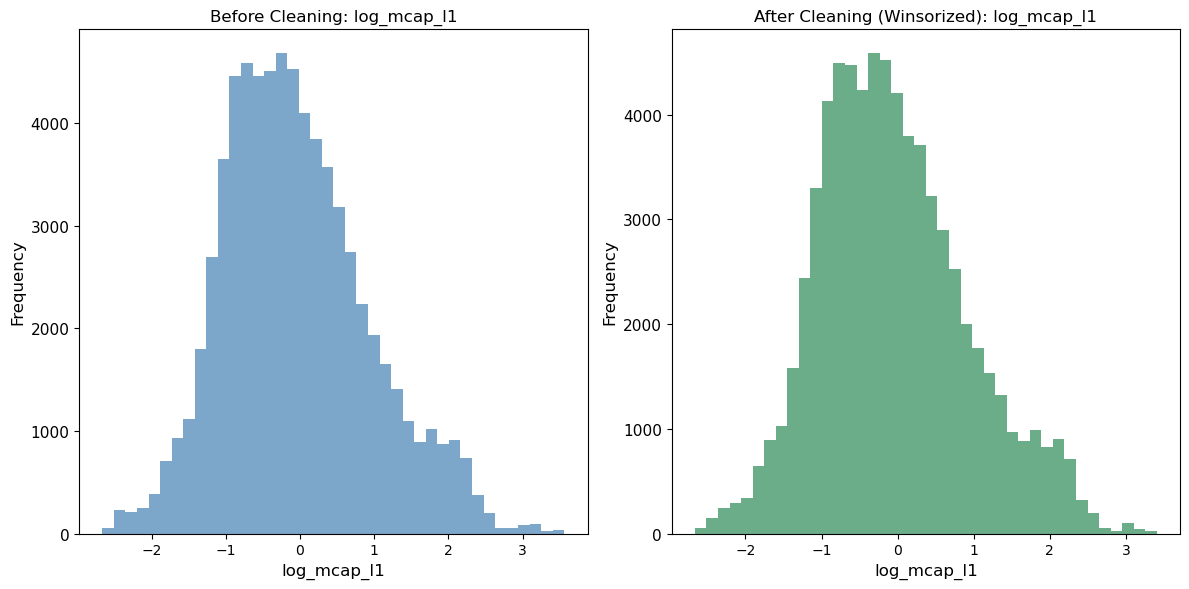

In [123]:
import matplotlib.pyplot as plt

# ----------------------------------------------
# HISTOGRAM BEFORE VS AFTER CLEANING
# ----------------------------------------------

# You MUST create this BEFORE overwriting train with winsorized version
# So STORE a copy before cleaning (put this before winsorize step)
# train_before_winsor = train.copy()

plt.figure(figsize=(12, 6))

# BEFORE CLEANING
plt.subplot(1, 2, 1)
plt.hist(train_before_winsor["log_mcap_l1"].dropna(), bins=40, alpha=0.7, color="steelblue")
plt.title("Before Cleaning: log_mcap_l1")
plt.xlabel("log_mcap_l1")
plt.ylabel("Frequency")

# AFTER CLEANING (WINSORIZED)
plt.subplot(1, 2, 2)
plt.hist(train["log_mcap_l1"].dropna(), bins=40, alpha=0.7, color="seagreen")
plt.title("After Cleaning (Winsorized): log_mcap_l1")
plt.xlabel("log_mcap_l1")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [81]:
# =====================================
# STEP 4 — CROSS-SECTIONAL Z-SCORES
# =====================================

def zscore_month(df, cols):
    df = df.copy()
    for date, grp in df.groupby("Date"):
        for col in cols:
            mean = grp[col].mean()
            std  = grp[col].std()
            df.loc[grp.index, col] = (grp[col] - mean) / std
    return df

train = zscore_month(train, feature_cols)
test  = zscore_month(test,  feature_cols)


In [82]:
# =====================================
# STEP 5 — DROP NaNs
# =====================================

train = train.dropna(subset = feature_cols + ["return"])
test  = test.dropna(subset = feature_cols + ["return"])

X_train = train[feature_cols]
y_train = train["return"]

X_test  = test[feature_cols]
y_test  = test["return"]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# X_train, y_train already defined

# 1) Time-series CV splitter
tscv = TimeSeriesSplit(n_splits=5)

# 2) Base RF model
rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

# 3) RF Hyperparameter grid tuned
param_grid = {
    "n_estimators": [300],
    "max_depth": [6, 9, 12],
    "min_samples_leaf": [5, 10],
    "max_features": ["sqrt"]
}

# 4) Grid search minimizing RMSE
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    refit=True
)

# 5) Fit on training data only
grid.fit(X_train, y_train)

# 6) Best model
rf_final = grid.best_estimator_
best_rmse = -grid.best_score_

print("Best params:", grid.best_params_)
print("Best CV RMSE:", best_rmse)

# 7) Re-run CV with best params to compute per-fold metrics
rf_best = RandomForestRegressor(
    **grid.best_params_,
    random_state=42,
    n_jobs=-1
)

fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), start=1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf_best.fit(X_tr, y_tr)
    y_pred = rf_best.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae  = mean_absolute_error(y_val, y_pred)

    std_ret  = y_val.std()
    mean_ret = y_val.mean()

    fold_metrics.append({
        "fold": fold,
        "rmse": rmse,
        "mae": mae,
        "std_returns": std_ret,
        "mean_returns": mean_ret
    })

cv_results_df = pd.DataFrame(fold_metrics)
print(cv_results_df)


Best params: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 300}
Best CV RMSE: 0.08097521700429573
   fold      rmse       mae  std_returns  mean_returns
0     1  0.088953  0.063769     0.086651      0.016769
1     2  0.068517  0.049314     0.068236      0.015714
2     3  0.076304  0.054957     0.076309      0.010476
3     4  0.074965  0.054687     0.075024      0.009687
4     5  0.096136  0.067912     0.096479      0.017500


In [84]:
# ============================================
# TRAIN & TEST RETURN STANDARD DEVIATION
# ============================================
import numpy as np

train_std = np.std(y_train)
test_std  = np.std(y_test)

print(f"Train Return Std: {train_std:.6f}")
print(f"Test Return Std : {test_std:.6f}")


Train Return Std: 0.089741
Test Return Std : 0.085562


In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predict on test set
y_pred_test = rf_final.predict(X_test)

# Compute metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae  = mean_absolute_error(y_test, y_pred_test)

print("Random Forest Test RMSE:", test_rmse)
print("Random Forest Test MAE :", test_mae)

Random Forest Test RMSE: 0.08563146577566903
Random Forest Test MAE : 0.06566863633707187


===== TOTAL RETURNS BY GROUP (1 = Highest Expected Returns) =====
Group 1    0.671573
Group 2    0.485614
Group 3    0.426867
Group 4    0.169936
Group 5    0.219248
Name: 2025-11-30 00:00:00, dtype: float64


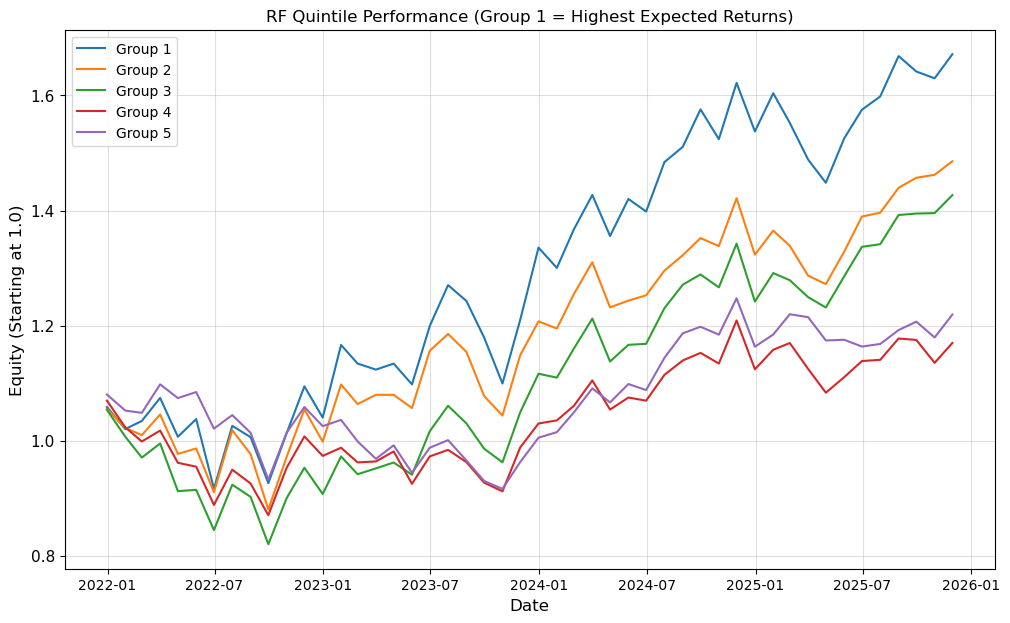

In [126]:
# ============================================================
# QUINTILE ANALYSIS — FINAL RF MODEL (Group 1 = Highest Exp Returns)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Predict returns for the test set using the tuned RF model
y_pred_test = rf_final.predict(X_test)

# 2) Attach predictions to the test DataFrame
bt = test.copy()
bt["pred_return"] = y_pred_test

# 3) Sort by date + predicted return (descending)
bt = bt.sort_values(["Date", "pred_return"], ascending=[True, False])

# 4) Assign 5 groups (quintiles) within each month
bt["group"] = bt.groupby("Date")["pred_return"].transform(
    lambda x: pd.qcut(
        x.rank(method="first", ascending=False),
        5,                 # <-- CHANGE HERE (was 10)
        labels=False
    )
)

# 5) Monthly equal-weighted return per group
group_ret = (
    bt.groupby(["Date", "group"])["return"]
      .mean()
      .unstack("group")
      .sort_index()
)

# 6) Equity curves for each group
group_equity = (1 + group_ret).cumprod()

# 7) Total returns for each group
total_group_returns = group_equity.iloc[-1] - 1
total_group_returns.index = [f"Group {i+1}" for i in total_group_returns.index]

print("===== TOTAL RETURNS BY GROUP (1 = Highest Expected Returns) =====")
print(total_group_returns)

# 8) Plot equity curves
plt.figure(figsize=(12, 7))
for g in group_equity.columns:
    plt.plot(group_equity.index,
             group_equity[g],
             label=f"Group {g+1}")
plt.title("RF Quintile Performance (Group 1 = Highest Expected Returns)")
plt.xlabel("Date")
plt.ylabel("Equity (Starting at 1.0)")
plt.grid(True, alpha=0.4)
plt.legend()
plt.show()

===== RF FEATURE IMPORTANCES (TRAIN) =====
            feature  importance
8    ma200_slope_l1    0.126427
6          vol60_l1    0.118472
7     ma50_slope_l1    0.116586
9       log_mcap_l1    0.096120
5          vol30_l1    0.071097
4        dist200_l1    0.057980
10          beta_l1    0.052917
12            de_l2    0.050705
1         mom_3m_l1    0.049912
16            bp_l2    0.041043
2         mom_6m_l1    0.039619
11           roe_l2    0.034503
3         dist50_l1    0.032088
17  revps_growth_l2    0.026467
0         mom_1m_l1    0.024169
14           npm_l2    0.023576
13     op_margin_l2    0.023531
15    earn_yield_l2    0.014786

===== RF PERMUTATION IMPORTANCES (TEST) =====
            feature    importance
9       log_mcap_l1  5.863509e-05
6          vol60_l1  1.908292e-05
3         dist50_l1  1.184328e-05
8    ma200_slope_l1  6.213991e-06
0         mom_1m_l1  5.325891e-06
17  revps_growth_l2  9.343012e-07
15    earn_yield_l2 -9.786008e-08
10          beta_l1 -8.532147e

/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/999164544.py:62: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


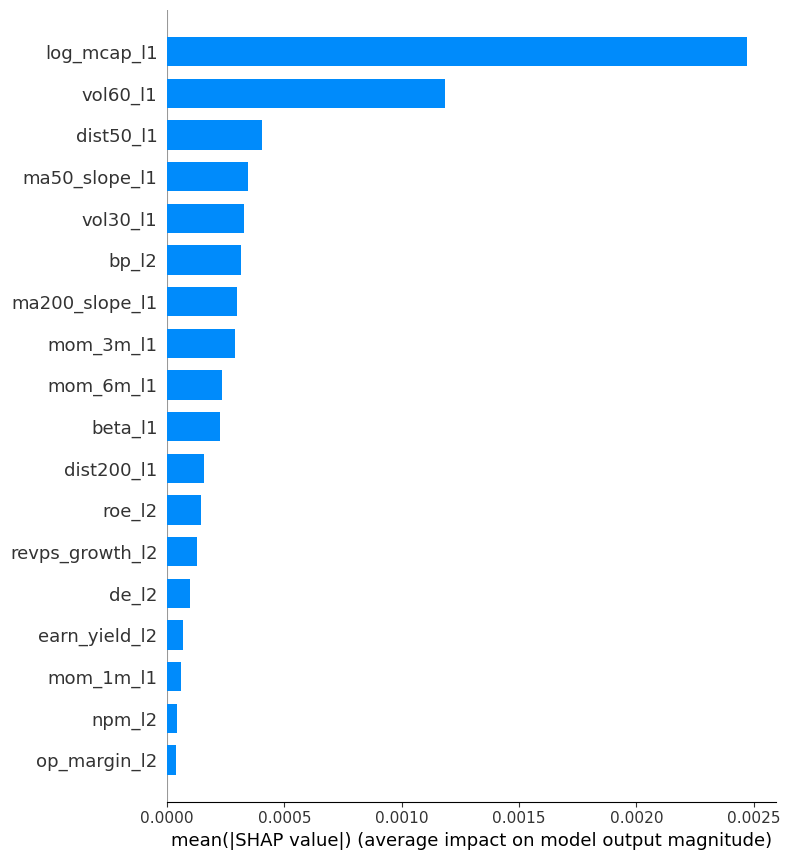

In [87]:
# ============================================================
# FEATURE IMPORTANCES + SHAP VALUES FOR RANDOM FOREST
# ============================================================

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# ============================================================
# 1) FEATURE IMPORTANCES (TRAIN)
# ============================================================

rf_train_pred = rf_final.predict(X_train)

train_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_final.feature_importances_
}).sort_values("importance", ascending=False)

print("===== RF FEATURE IMPORTANCES (TRAIN) =====")
print(train_importances)


# ============================================================
# 2) PERMUTATION IMPORTANCES (TEST)
# ============================================================

perm_test = permutation_importance(
    rf_final,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    scoring="neg_root_mean_squared_error"
)

test_importances = pd.DataFrame({
    "feature": X_test.columns,
    "importance": perm_test.importances_mean
}).sort_values("importance", ascending=False)

print("\n===== RF PERMUTATION IMPORTANCES (TEST) =====")
print(test_importances)


# ============================================================
# 3) SHAP VALUES (TREE EXPLAINER)
# ============================================================

shap.initjs()

explainer = shap.TreeExplainer(rf_final)
shap_values = explainer.shap_values(X_test)


# ============================================================
# 4) SHAP BAR PLOT (OPTIONAL)
# ============================================================

shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar"
)


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# X_train, y_train already defined (pandas DataFrame / Series)

# 1) Time-series CV splitter
tscv = TimeSeriesSplit(n_splits=5)

# 2) Base XGBoost model
xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",   # good default for speed
    random_state=42,
    n_jobs=-1
)

# 3) XGB Hyperparameter grid 
param_grid = {
    "n_estimators": [400],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [5]
}

# 4) Grid search with TimeSeriesSplit, minimizing RMSE
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",  # maximize => minimize RMSE
    n_jobs=-1,
    refit=True
)

# 5) Fit on training data only
grid_xgb.fit(X_train, y_train)

# 6) Best model trained on full train set
xgb_final = grid_xgb.best_estimator_
best_rmse_xgb = -grid_xgb.best_score_

print("Best XGB params:", grid_xgb.best_params_)
print("Best XGB CV RMSE:", best_rmse_xgb)

# 7) Re-run CV with best params to compute per-fold metrics
xgb_best = XGBRegressor(
    **grid_xgb.best_params_,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

fold_metrics_xgb = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), start=1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    xgb_best.fit(X_tr, y_tr)
    y_pred = xgb_best.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae  = mean_absolute_error(y_val, y_pred)

    std_ret  = y_val.std()
    mean_ret = y_val.mean()

    fold_metrics_xgb.append({
        "fold": fold,
        "rmse": rmse,
        "mae": mae,
        "std_returns": std_ret,
        "mean_returns": mean_ret
    })

cv_results_xgb = pd.DataFrame(fold_metrics_xgb)
print(cv_results_xgb)

Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 400, 'subsample': 0.8}
Best XGB CV RMSE: 0.08257240778243266
   fold      rmse       mae  std_returns  mean_returns
0     1  0.092876  0.065919     0.086651      0.016769
1     2  0.070859  0.050768     0.068236      0.015714
2     3  0.077437  0.055636     0.076309      0.010476
3     4  0.075321  0.054909     0.075024      0.009687
4     5  0.096369  0.068046     0.096479      0.017500


In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# xgb_final should be your best XGBoost model from GridSearchCV
# X_test and y_test already defined

# 1) Predict on the test set
y_pred_test_xgb = xgb_final.predict(X_test)

# 2) Compute RMSE and MAE
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
xgb_test_mae  = mean_absolute_error(y_test, y_pred_test_xgb)

print("XGBoost Test RMSE:", xgb_test_rmse)
print("XGBoost Test MAE :", xgb_test_mae)

XGBoost Test RMSE: 0.08628668444883573
XGBoost Test MAE : 0.0661524822992863


===== XGB TOTAL RETURNS BY GROUP (1 = Highest Expected Returns) =====
Group 1    0.553315
Group 2    0.465824
Group 3    0.353519
Group 4    0.292282
Group 5    0.276335
Name: 2025-11-30 00:00:00, dtype: float64


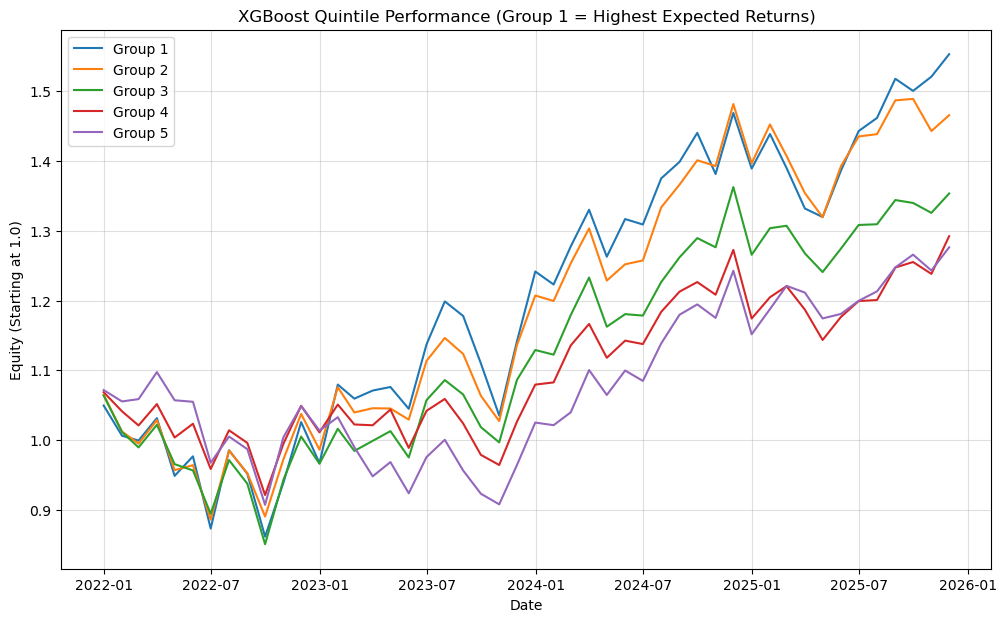

In [90]:
# ============================================================
# QUINTILE BACKTEST — XGBoost FINAL MODEL
# Group 1 = Highest Expected Returns, Group 5 = Lowest
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Predict returns for the test set using the tuned XGB model
y_pred_test_xgb = xgb_final.predict(X_test)

# 2) Attach predictions to the test DataFrame
bt_xgb = test.copy()
bt_xgb["pred_return"] = y_pred_test_xgb

# 3) Sort by date + predicted return (descending)
bt_xgb = bt_xgb.sort_values(["Date", "pred_return"], ascending=[True, False])

# 4) Assign 5 groups (quintiles) within each month
# Group 0 -> Group 1 (highest preds), Group 4 -> Group 5 (lowest preds)
bt_xgb["group"] = bt_xgb.groupby("Date")["pred_return"].transform(
    lambda x: pd.qcut(
        x.rank(method="first", ascending=False),
        5,               # 5 buckets = quintiles
        labels=False
    )
)

# 5) Monthly equal-weighted return per group
group_ret_xgb = (
    bt_xgb.groupby(["Date", "group"])["return"]
          .mean()
          .unstack("group")
          .sort_index()
)

# 6) Equity curves for each group
group_equity_xgb = (1 + group_ret_xgb).cumprod()

# 7) Total returns for each group over the whole test period
total_group_returns_xgb = group_equity_xgb.iloc[-1] - 1
total_group_returns_xgb.index = [f"Group {i+1}" for i in total_group_returns_xgb.index]

print("===== XGB TOTAL RETURNS BY GROUP (1 = Highest Expected Returns) =====")
print(total_group_returns_xgb)

# 8) Plot equity curves for all 5 groups
plt.figure(figsize=(12, 7))
for g in group_equity_xgb.columns:
    plt.plot(group_equity_xgb.index,
             group_equity_xgb[g],
             label=f"Group {g+1}")
plt.title("XGBoost Quintile Performance (Group 1 = Highest Expected Returns)")
plt.xlabel("Date")
plt.ylabel("Equity (Starting at 1.0)")
plt.grid(True, alpha=0.4)
plt.legend()
plt.show()

In [ ]:
# ============================================================
# ADABOOST REGRESSOR — TIME SERIES CV + HYPERPARAM TUNING
# ============================================================
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# X_train, y_train are already defined (pandas DataFrame / Series)

# 1) Time-series CV splitter
tscv = TimeSeriesSplit(n_splits=5)

# 2) Base AdaBoost regressor (with a shallow tree as base learner)
base_tree = DecisionTreeRegressor(
    random_state=42,
    max_depth=3
)

ada = AdaBoostRegressor(
    estimator=base_tree,      # <- updated (was base_estimator)
    random_state=42
)

# 3) AdaBoost Hyperparameter grid
param_grid_ada = {
    "n_estimators": [100, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "estimator__max_depth": [2, 3, 4]   
}

# 4) Grid search with TimeSeriesSplit, minimizing RMSE
grid_ada = GridSearchCV(
    estimator=ada,
    param_grid=param_grid_ada,
    cv=tscv,
    scoring="neg_root_mean_squared_error",  # maximize => minimize RMSE
    n_jobs=-1,
    refit=True
)

# 5) Fit on training data only
grid_ada.fit(X_train, y_train)

# 6) Best model trained on full train set
ada_final = grid_ada.best_estimator_
best_rmse_ada = -grid_ada.best_score_

print("Best AdaBoost params:", grid_ada.best_params_)
print("Best AdaBoost CV RMSE:", best_rmse_ada)

# 7) Re-run CV with best params to compute per-fold metrics
ada_best = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(
        random_state=42,
        max_depth=grid_ada.best_params_["estimator__max_depth"]  # <- updated key
    ),
    n_estimators=grid_ada.best_params_["n_estimators"],
    learning_rate=grid_ada.best_params_["learning_rate"],
    random_state=42
)

fold_metrics_ada = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), start=1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    ada_best.fit(X_tr, y_tr)
    y_pred = ada_best.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))  # RMSE
    mae  = mean_absolute_error(y_val, y_pred)

    std_ret  = y_val.std()
    mean_ret = y_val.mean()

    fold_metrics_ada.append({
        "fold": fold,
        "rmse": rmse,
        "mae": mae,
        "std_returns": std_ret,
        "mean_returns": mean_ret
    })

cv_results_ada = pd.DataFrame(fold_metrics_ada)
print(cv_results_ada)


/Users/rishi/Documents/anaconda3/envs/ds/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best AdaBoost params: {'estimator__max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 100}
Best AdaBoost CV RMSE: 0.08139530580173235
   fold      rmse       mae  std_returns  mean_returns
0     1  0.088648  0.063437     0.086651      0.016769
1     2  0.069785  0.049276     0.068236      0.015714
2     3  0.076791  0.055119     0.076309      0.010476
3     4  0.075121  0.054723     0.075024      0.009687
4     5  0.096632  0.067979     0.096479      0.017500


In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predict on test set with final AdaBoost model
y_pred_test_ada = ada_final.predict(X_test)

# Compute RMSE and MAE
ada_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_ada))
ada_test_mae  = mean_absolute_error(y_test, y_pred_test_ada)

print("AdaBoost Test RMSE:", ada_test_rmse)
print("AdaBoost Test MAE :", ada_test_mae)

AdaBoost Test RMSE: 0.08568225840780298
AdaBoost Test MAE : 0.06565019246002561


===== AdaBoost TOTAL RETURNS BY GROUP (1 = Highest Expected Returns) =====
Group 1    0.688677
Group 2    0.518916
Group 3    0.231292
Group 4    0.317867
Group 5    0.230960
Name: 2025-11-30 00:00:00, dtype: float64


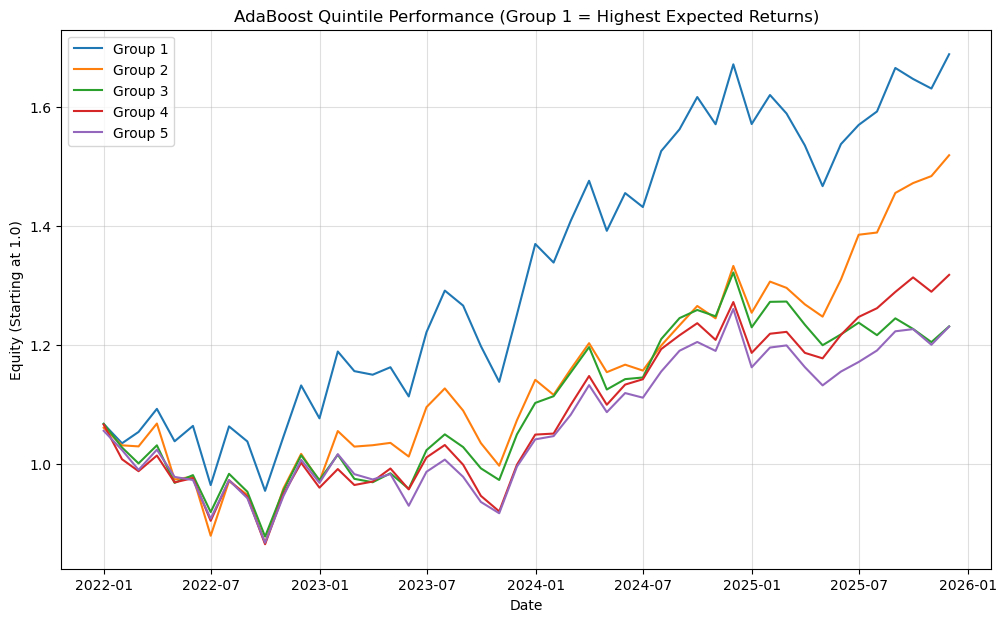

In [93]:
# ============================================================
# QUINTILE BACKTEST — AdaBoost FINAL MODEL
# Group 1 = Highest Expected Returns, Group 5 = Lowest
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Predict returns for the test set using the tuned AdaBoost model
y_pred_test_ada = ada_final.predict(X_test)

# 2) Attach predictions to the test DataFrame
bt_ada = test.copy()
bt_ada["pred_return"] = y_pred_test_ada

# 3) Sort by date + predicted return (descending)
bt_ada = bt_ada.sort_values(["Date", "pred_return"], ascending=[True, False])

# 4) Assign 5 groups (quintiles) within each month
# Group 0 -> Group 1 (highest preds), Group 4 -> Group 5 (lowest preds)
bt_ada["group"] = bt_ada.groupby("Date")["pred_return"].transform(
    lambda x: pd.qcut(
        x.rank(method="first", ascending=False),
        5,               # 5 buckets = quintiles
        labels=False
    )
)

# 5) Monthly equal-weighted return per group
group_ret_ada = (
    bt_ada.groupby(["Date", "group"])["return"]
          .mean()
          .unstack("group")
          .sort_index()
)

# 6) Equity curves for each group
group_equity_ada = (1 + group_ret_ada).cumprod()

# 7) Total returns for each group over the whole test period
total_group_returns_ada = group_equity_ada.iloc[-1] - 1
total_group_returns_ada.index = [f"Group {i+1}" for i in total_group_returns_ada.index]

print("===== AdaBoost TOTAL RETURNS BY GROUP (1 = Highest Expected Returns) =====")
print(total_group_returns_ada)

# 8) Plot equity curves for all 5 groups
plt.figure(figsize=(12, 7))
for g in group_equity_ada.columns:
    plt.plot(group_equity_ada.index,
             group_equity_ada[g],
             label=f"Group {g+1}")
plt.title("AdaBoost Quintile Performance (Group 1 = Highest Expected Returns)")
plt.xlabel("Date")
plt.ylabel("Equity (Starting at 1.0)")
plt.grid(True, alpha=0.4)
plt.legend()
plt.show()

In [ ]:
# ============================================================
# ANN (MLP) REGRESSOR — TIME SERIES CV + HYPERPARAM TUNING
# ============================================================
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Make sure X_train, y_train, train (with "Date" and "return") already exist

tf.random.set_seed(42)

# --------- 1) Model builder for ANN ----------
def build_ann_model(input_dim, hidden_units=64, dropout_rate=0.0, lr=1e-3):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(hidden_units, activation="relu"))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(hidden_units // 2, activation="relu"))
    model.add(layers.Dense(1))   # regression output

    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="mse")
    return model

# --------- 2) ANN Hyperparameter grid ----------
param_grid_ann = [
    {"hidden_units": 32, "dropout_rate": 0.0, "lr": 1e-3, "batch_size": 256, "epochs": 30},
    {"hidden_units": 64, "dropout_rate": 0.0, "lr": 1e-3, "batch_size": 256, "epochs": 30},
    {"hidden_units": 64, "dropout_rate": 0.2, "lr": 1e-3, "batch_size": 256, "epochs": 30},
    {"hidden_units": 128, "dropout_rate": 0.2, "lr": 1e-3, "batch_size": 256, "epochs": 30},
]

tscv = TimeSeriesSplit(n_splits=5)

best_params_ann = None
best_cv_rmse_ann = np.inf
best_fold_metrics_ann = None

input_dim = X_train.shape[1]

# --------- 3) Manual grid search with TimeSeriesSplit ----------
for params in param_grid_ann:
    print("Testing params:", params)
    fold_metrics = []
    rmses_for_mean = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), start=1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Build a fresh model for this fold
        model = build_ann_model(
            input_dim=input_dim,
            hidden_units=params["hidden_units"],
            dropout_rate=params["dropout_rate"],
            lr=params["lr"]
        )

        history = model.fit(
            X_tr,
            y_tr,
            validation_data=(X_val, y_val),
            epochs=params["epochs"],
            batch_size=params["batch_size"],
            verbose=0
        )

        y_pred = model.predict(X_val, verbose=0).ravel()

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae  = mean_absolute_error(y_val, y_pred)
        std_ret  = y_val.std()
        mean_ret = y_val.mean()

        fold_metrics.append({
            "fold": fold,
            "rmse": rmse,
            "mae": mae,
            "std_returns": std_ret,
            "mean_returns": mean_ret
        })
        rmses_for_mean.append(rmse)

    mean_rmse = np.mean(rmses_for_mean)
    print("Mean CV RMSE for these params:", mean_rmse)

    if mean_rmse < best_cv_rmse_ann:
        best_cv_rmse_ann = mean_rmse
        best_params_ann = params
        best_fold_metrics_ann = pd.DataFrame(fold_metrics)

print("\n===== BEST ANN PARAMS =====")
print(best_params_ann)
print("Best ANN CV RMSE:", best_cv_rmse_ann)
print("\n===== PER-FOLD METRICS (BEST ANN CONFIG) =====")
print(best_fold_metrics_ann)

# --------- 4) Refit best ANN on full training set ----------
ann_final = build_ann_model(
    input_dim=input_dim,
    hidden_units=best_params_ann["hidden_units"],
    dropout_rate=best_params_ann["dropout_rate"],
    lr=best_params_ann["lr"]
)

ann_final.fit(
    X_train,
    y_train,
    epochs=best_params_ann["epochs"],
    batch_size=best_params_ann["batch_size"],
    verbose=0
)

Testing params: {'hidden_units': 32, 'dropout_rate': 0.0, 'lr': 0.001, 'batch_size': 256, 'epochs': 30}
Mean CV RMSE for these params: 0.08496914498187931
Testing params: {'hidden_units': 64, 'dropout_rate': 0.0, 'lr': 0.001, 'batch_size': 256, 'epochs': 30}
Mean CV RMSE for these params: 0.08757912202773699
Testing params: {'hidden_units': 64, 'dropout_rate': 0.2, 'lr': 0.001, 'batch_size': 256, 'epochs': 30}
Mean CV RMSE for these params: 0.08243220744354704
Testing params: {'hidden_units': 128, 'dropout_rate': 0.2, 'lr': 0.001, 'batch_size': 256, 'epochs': 30}
Mean CV RMSE for these params: 0.08329312172826736

===== BEST ANN PARAMS =====
{'hidden_units': 64, 'dropout_rate': 0.2, 'lr': 0.001, 'batch_size': 256, 'epochs': 30}
Best ANN CV RMSE: 0.08243220744354704

===== PER-FOLD METRICS (BEST ANN CONFIG) =====
   fold      rmse       mae  std_returns  mean_returns
0     1  0.093230  0.067645     0.086651      0.016769
1     2  0.069902  0.050114     0.068236      0.015714
2     3  0.

In [95]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predict on test set with final ANN model
y_pred_test_ann = ann_final.predict(X_test, verbose=0).ravel()

# Compute RMSE and MAE
ann_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_ann))
ann_test_mae  = mean_absolute_error(y_test, y_pred_test_ann)

print("ANN Test RMSE:", ann_test_rmse)
print("ANN Test MAE :", ann_test_mae)

ANN Test RMSE: 0.08608269201763284
ANN Test MAE : 0.06600590056410151


===== ANN TOTAL RETURNS BY GROUP (1 = Highest Expected Returns) =====
Group 1    0.713479
Group 2    0.250547
Group 3    0.372452
Group 4    0.257516
Group 5    0.380707
Name: 2025-11-30 00:00:00, dtype: float64


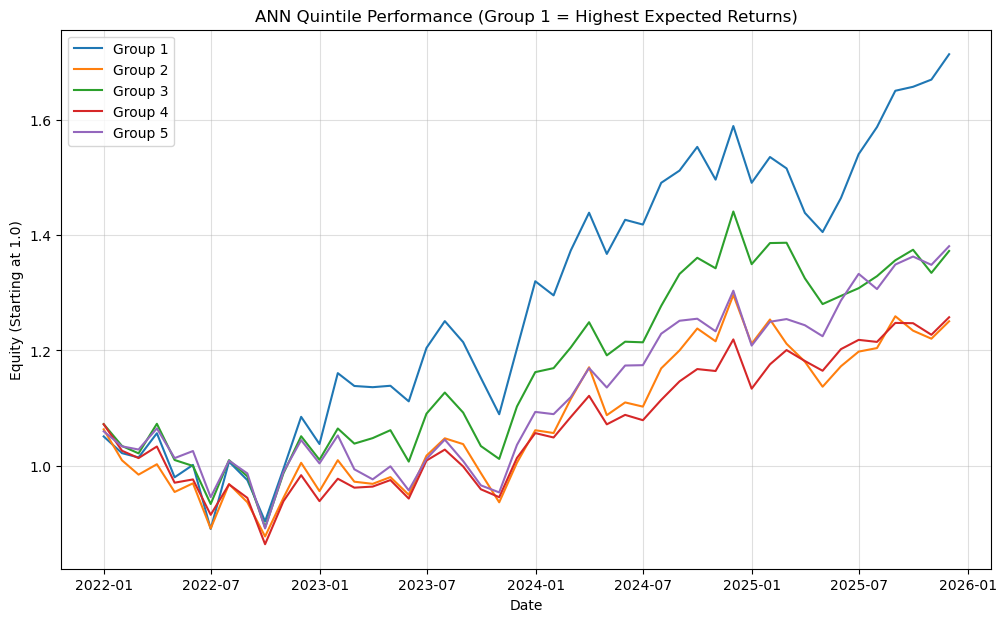

In [96]:
# ============================================================
# QUINTILE BACKTEST — ANN FINAL MODEL
# Group 1 = Highest Expected Returns, Group 5 = Lowest
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Predict returns for the test set using the ANN
y_pred_test_ann = ann_final.predict(X_test, verbose=0).ravel()

# 2) Attach predictions to the test DataFrame
bt_ann = test.copy()
bt_ann["pred_return"] = y_pred_test_ann

# 3) Sort by date + predicted return (descending)
bt_ann = bt_ann.sort_values(["Date", "pred_return"], ascending=[True, False])

# 4) Assign 5 groups (quintiles) within each month
bt_ann["group"] = bt_ann.groupby("Date")["pred_return"].transform(
    lambda x: pd.qcut(
        x.rank(method="first", ascending=False),
        5,                  # 5 buckets = quintiles
        labels=False
    )
)

# 5) Monthly equal-weighted return per group
group_ret_ann = (
    bt_ann.groupby(["Date", "group"])["return"]
          .mean()
          .unstack("group")
          .sort_index()
)

# 6) Equity curves for each group
group_equity_ann = (1 + group_ret_ann).cumprod()

# 7) Total returns for each group over the whole test period
total_group_returns_ann = group_equity_ann.iloc[-1] - 1
total_group_returns_ann.index = [f"Group {i+1}" for i in total_group_returns_ann.index]

print("===== ANN TOTAL RETURNS BY GROUP (1 = Highest Expected Returns) =====")
print(total_group_returns_ann)

# 8) Plot equity curves for all 5 groups
plt.figure(figsize=(12, 7))
for g in group_equity_ann.columns:
    plt.plot(group_equity_ann.index,
             group_equity_ann[g],
             label=f"Group {g+1}")
plt.title("ANN Quintile Performance (Group 1 = Highest Expected Returns)")
plt.xlabel("Date")
plt.ylabel("Equity (Starting at 1.0)")
plt.grid(True, alpha=0.4)
plt.legend()
plt.show()

In [97]:
# ============================================================
# OLS (Linear Regression) — TIME SERIES CV
# ============================================================
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# X_train, y_train, train (with "Date" and "return") already defined

# 1) Time-series CV splitter
tscv = TimeSeriesSplit(n_splits=5)

# 2) Base OLS model (no hyperparameters)
ols = LinearRegression()

fold_metrics_ols = []
rmses_for_mean_ols = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), start=1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    ols.fit(X_tr, y_tr)
    y_pred = ols.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae  = mean_absolute_error(y_val, y_pred)
    std_ret  = y_val.std()
    mean_ret = y_val.mean()

    fold_metrics_ols.append({
        "fold": fold,
        "rmse": rmse,
        "mae": mae,
        "std_returns": std_ret,
        "mean_returns": mean_ret
    })
    rmses_for_mean_ols.append(rmse)

ols_cv_results = pd.DataFrame(fold_metrics_ols)
ols_mean_cv_rmse = np.mean(rmses_for_mean_ols)

print("===== OLS PER-FOLD METRICS =====")
print(ols_cv_results)
print("\nOLS Mean CV RMSE:", ols_mean_cv_rmse)

# 3) Refit OLS on full training set for final model
ols_final = LinearRegression()
ols_final.fit(X_train, y_train)

===== OLS PER-FOLD METRICS =====
   fold      rmse       mae  std_returns  mean_returns
0     1  0.088414  0.063717     0.086651      0.016769
1     2  0.069473  0.050051     0.068236      0.015714
2     3  0.076477  0.055263     0.076309      0.010476
3     4  0.075292  0.054928     0.075024      0.009687
4     5  0.096134  0.067816     0.096479      0.017500

OLS Mean CV RMSE: 0.0811579716495117


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [98]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predict on test set with final OLS model
y_pred_test_ols = ols_final.predict(X_test)

# Compute RMSE and MAE
ols_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_ols))
ols_test_mae  = mean_absolute_error(y_test, y_pred_test_ols)

print("OLS Test RMSE:", ols_test_rmse)
print("OLS Test MAE :", ols_test_mae)

OLS Test RMSE: 0.08588903036859023
OLS Test MAE : 0.06596696225859901


===== OLS TOTAL RETURNS BY GROUP (1 = Highest Expected Returns) =====
Group 1    0.711374
Group 2    0.442451
Group 3    0.229192
Group 4    0.201947
Group 5    0.389933
Name: 2025-11-30 00:00:00, dtype: float64


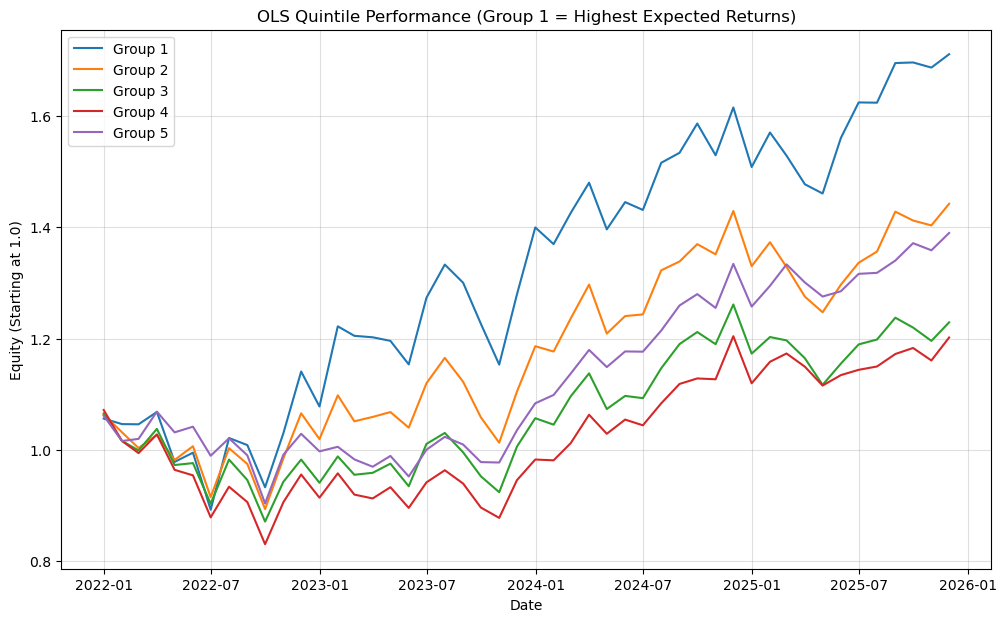

In [99]:
# ============================================================
# QUINTILE BACKTEST — OLS FINAL MODEL
# Group 1 = Highest Expected Returns, Group 5 = Lowest
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Predict returns for the test set using the final OLS model
y_pred_test_ols = ols_final.predict(X_test)

# 2) Attach predictions to the test DataFrame
bt_ols = test.copy()
bt_ols["pred_return"] = y_pred_test_ols

# 3) Sort by date + predicted return (descending)
bt_ols = bt_ols.sort_values(["Date", "pred_return"], ascending=[True, False])

# 4) Assign 5 groups (quintiles) within each month
bt_ols["group"] = bt_ols.groupby("Date")["pred_return"].transform(
    lambda x: pd.qcut(
        x.rank(method="first", ascending=False),
        5,                  # 5 buckets = quintiles
        labels=False
    )
)

# 5) Monthly equal-weighted return per group
group_ret_ols = (
    bt_ols.groupby(["Date", "group"])["return"]
          .mean()
          .unstack("group")
          .sort_index()
)

# 6) Equity curves for each group
group_equity_ols = (1 + group_ret_ols).cumprod()

# 7) Total returns for each group over the whole test period
total_group_returns_ols = group_equity_ols.iloc[-1] - 1
total_group_returns_ols.index = [f"Group {i+1}" for i in total_group_returns_ols.index]

print("===== OLS TOTAL RETURNS BY GROUP (1 = Highest Expected Returns) =====")
print(total_group_returns_ols)

# 8) Plot equity curves for all 5 groups
plt.figure(figsize=(12, 7))
for g in group_equity_ols.columns:
    plt.plot(group_equity_ols.index,
             group_equity_ols[g],
             label=f"Group {g+1}")
plt.title("OLS Quintile Performance (Group 1 = Highest Expected Returns)")
plt.xlabel("Date")
plt.ylabel("Equity (Starting at 1.0)")
plt.grid(True, alpha=0.4)
plt.legend()
plt.show()

In [100]:
import numpy as np
import pandas as pd

# ============================================================
# PEARSON ICs ON TEST DATA FOR RF, XGB, ADABOOST, ANN, OLS
# ============================================================

# 1) Copy test DataFrame and add predictions
bt_ic_p = test.copy()
bt_ic_p["pred_rf"]   = rf_final.predict(X_test)
bt_ic_p["pred_xgb"]  = xgb_final.predict(X_test)
bt_ic_p["pred_ada"]  = ada_final.predict(X_test)
bt_ic_p["pred_ann"]  = ann_final.predict(X_test, verbose=0).ravel()
bt_ic_p["pred_ols"]  = ols_final.predict(X_test)

# 2) Function to compute cross-sectional PEARSON correlations per month
def compute_ic_group_pearson(df):
    corr = df[[
        "return",
        "pred_rf", "pred_xgb", "pred_ada",
        "pred_ann", "pred_ols"
    ]].corr(method="pearson")
    return corr.loc["return", [
        "pred_rf", "pred_xgb", "pred_ada",
        "pred_ann", "pred_ols"
    ]]

# 3) Apply monthly
pearson_ic_df = (
    bt_ic_p.groupby("Date")
           .apply(compute_ic_group_pearson)
)

pearson_ic_df.columns = [
    "IC_rf_pearson",
    "IC_xgb_pearson",
    "IC_ada_pearson",
    "IC_ann_pearson",
    "IC_ols_pearson"
]

# 4) Summary stats
pearson_ic_summary = pd.DataFrame({
    "avg_ic": pearson_ic_df.mean(),
    "ic_std": pearson_ic_df.std(),
    "ic_sharpe": pearson_ic_df.mean() / pearson_ic_df.std()
})

print("===== MONTHLY PEARSON ICs (TEST PERIOD) =====")
print(pearson_ic_df.head())

print("\n===== PEARSON IC SUMMARY (TEST PERIOD) =====")
print(pearson_ic_summary)


===== MONTHLY PEARSON ICs (TEST PERIOD) =====
            IC_rf_pearson  IC_xgb_pearson  IC_ada_pearson  IC_ann_pearson  \
Date                                                                        
2021-12-31      -0.087419       -0.215014       -0.062046       -0.086074   
2022-01-31      -0.009397       -0.132395        0.045662        0.022749   
2022-02-28       0.111551       -0.077507        0.145163       -0.120396   
2022-03-31       0.045216        0.058422        0.039740        0.030033   
2022-04-30      -0.051631       -0.198234        0.095239       -0.125984   

            IC_ols_pearson  
Date                        
2021-12-31       -0.034554  
2022-01-31        0.187216  
2022-02-28        0.011230  
2022-03-31       -0.080634  
2022-04-30       -0.165448  

===== PEARSON IC SUMMARY (TEST PERIOD) =====
                  avg_ic    ic_std  ic_sharpe
IC_rf_pearson   0.036780  0.156174   0.235505
IC_xgb_pearson  0.022707  0.158218   0.143518
IC_ada_pearson  0.023949  0

/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/168227284.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_ic_group_pearson)


In [101]:
import numpy as np
import pandas as pd

# ============================================================
# SPEARMAN ICs — TRAIN & TEST FOR ALL MODELS
# Models: RF, XGB, Ada, ANN, OLS
# ============================================================

# ---------- 1) Build train + preds ----------
bt_train = train.copy()

bt_train["pred_rf"]   = rf_final.predict(X_train)
bt_train["pred_xgb"]  = xgb_final.predict(X_train)
bt_train["pred_ada"]  = ada_final.predict(X_train)
bt_train["pred_ann"]  = ann_final.predict(X_train, verbose=0).ravel()
bt_train["pred_ols"]  = ols_final.predict(X_train)

# ---------- 2) Build test + preds ----------
bt_test = test.copy()

bt_test["pred_rf"]   = rf_final.predict(X_test)
bt_test["pred_xgb"]  = xgb_final.predict(X_test)
bt_test["pred_ada"]  = ada_final.predict(X_test)
bt_test["pred_ann"]  = ann_final.predict(X_test, verbose=0).ravel()
bt_test["pred_ols"]  = ols_final.predict(X_test)

# ---------- 3) Helper: compute monthly Spearman ICs ----------
def compute_spearman_ics(df):
    corr = df[[
        "return",
        "pred_rf", "pred_xgb", "pred_ada",
        "pred_ann", "pred_ols"
    ]].corr(method="spearman")
    return corr.loc["return", [
        "pred_rf", "pred_xgb", "pred_ada",
        "pred_ann", "pred_ols"
    ]]

# Train ICs
ic_train_df = (
    bt_train.groupby("Date")
            .apply(compute_spearman_ics)
)

ic_train_df.columns = [
    "IC_rf_train",
    "IC_xgb_train",
    "IC_ada_train",
    "IC_ann_train",
    "IC_ols_train"
]

# Test ICs
ic_test_df = (
    bt_test.groupby("Date")
           .apply(compute_spearman_ics)
)

ic_test_df.columns = [
    "IC_rf_test",
    "IC_xgb_test",
    "IC_ada_test",
    "IC_ann_test",
    "IC_ols_test"
]

# ---------- 4) Summary: avg IC + IC Sharpe (mean/std) ----------
models = ["rf", "xgb", "ada", "ann", "ols"]

summary_rows = []

for m in models:
    train_ic = ic_train_df[f"IC_{m}_train"]
    test_ic  = ic_test_df[f"IC_{m}_test"]

    train_avg_ic = train_ic.mean()
    train_ic_std = train_ic.std()
    train_ic_sharpe = train_avg_ic / train_ic_std if train_ic_std != 0 else np.nan

    test_avg_ic = test_ic.mean()
    test_ic_std = test_ic.std()
    test_ic_sharpe = test_avg_ic / test_ic_std if test_ic_std != 0 else np.nan

    summary_rows.append({
        "model": m.upper(),
        "train_avg_ic": train_avg_ic,
        "train_ic_sharpe": train_ic_sharpe,
        "test_avg_ic": test_avg_ic,
        "test_ic_sharpe": test_ic_sharpe
    })

ic_summary_all = pd.DataFrame(summary_rows).set_index("model")

print("===== SPEARMAN IC SUMMARY — TRAIN & TEST =====")
print(ic_summary_all)

# If you also want to inspect the raw monthly ICs:
# print(ic_train_df.head())
# print(ic_test_df.head())


===== SPEARMAN IC SUMMARY — TRAIN & TEST =====
       train_avg_ic  train_ic_sharpe  test_avg_ic  test_ic_sharpe
model                                                            
RF         0.091396         0.660703     0.016285        0.092749
XGB        0.133017         1.063470     0.010905        0.065660
ADA        0.057709         0.608326     0.018090        0.165819
ANN        0.092160         0.851971     0.005864        0.050671
OLS        0.061939         0.349412     0.004806        0.026524


/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/1961305340.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_spearman_ics)
/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/1961305340.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_spearman_ics)


In [102]:
import numpy as np
import pandas as pd

# ============================================================
# MONTHLY QUINTILE SPREAD SUMMARY (TRAIN & TEST)
# Models: RF, XGB, Ada, ANN, OLS
# ============================================================

# ---------- 1) Attach predictions to TRAIN ----------
bt_train = train.copy()
bt_train["pred_rf"]   = rf_final.predict(X_train)
bt_train["pred_xgb"]  = xgb_final.predict(X_train)
bt_train["pred_ada"]  = ada_final.predict(X_train)
bt_train["pred_ann"]  = ann_final.predict(X_train, verbose=0).ravel()
bt_train["pred_ols"]  = ols_final.predict(X_train)

# ---------- 2) Attach predictions to TEST ----------
bt_test = test.copy()
bt_test["pred_rf"]   = rf_final.predict(X_test)
bt_test["pred_xgb"]  = xgb_final.predict(X_test)
bt_test["pred_ada"]  = ada_final.predict(X_test)
bt_test["pred_ann"]  = ann_final.predict(X_test, verbose=0).ravel()
bt_test["pred_ols"]  = ols_final.predict(X_test)

# ---------- 3) Helper: compute *monthly* Q1, Q5, and spread ----------
def compute_monthly_spread(df, pred_col, n_groups=5):

    tmp = df.copy()
    tmp = tmp.sort_values(["Date", pred_col], ascending=[True, False])

    # assign quintiles per month (0 = highest expected return)
    tmp["group"] = tmp.groupby("Date")[pred_col].transform(
        lambda x: pd.qcut(
            x.rank(method="first", ascending=False),
            n_groups,
            labels=False
        )
    )

    # equal-weighted monthly returns per quintile
    grp_ret = (
        tmp.groupby(["Date", "group"])["return"]
           .mean()
           .unstack("group")
           .sort_index()
    )

    # -------- KEY CHANGE: USE MONTHLY AVERAGES --------
    q1_mean = grp_ret[0].mean()
    q5_mean = grp_ret[n_groups - 1].mean()
    spread_mean = q1_mean - q5_mean

    return q1_mean, q5_mean, spread_mean

# ---------- 4) Loop over models ----------
models = {
    "RF":  "pred_rf",
    "XGB": "pred_xgb",
    "ADA": "pred_ada",
    "ANN": "pred_ann",
    "OLS": "pred_ols"
}

rows = []

for name, col in models.items():
    # train
    train_q1, train_q5, train_spread = compute_monthly_spread(bt_train, col)
    # test
    test_q1,  test_q5,  test_spread  = compute_monthly_spread(bt_test, col)

    rows.append({
        "model": name,
        "train_q1_mean_ret": train_q1,
        "train_q5_mean_ret": train_q5,
        "train_q1_minus_q5": train_spread,
        "test_q1_mean_ret":  test_q1,
        "test_q5_mean_ret":  test_q5,
        "test_q1_minus_q5":  test_spread
    })

monthly_spread_summary = pd.DataFrame(rows).set_index("model")

print("===== MONTHLY QUINTILE SPREAD SUMMARY (MEAN MONTHLY RETURNS) =====")
print(monthly_spread_summary)

===== MONTHLY QUINTILE SPREAD SUMMARY (MEAN MONTHLY RETURNS) =====
       train_q1_mean_ret  train_q5_mean_ret  train_q1_minus_q5  \
model                                                            
RF              0.027696           0.002358           0.025338   
XGB             0.032963          -0.003499           0.036462   
ADA             0.022425           0.007497           0.014927   
ANN             0.027548           0.001108           0.026440   
OLS             0.022289           0.004924           0.017365   

       test_q1_mean_ret  test_q5_mean_ret  test_q1_minus_q5  
model                                                        
RF             0.012305          0.004827          0.007478  
XGB            0.010752          0.005948          0.004805  
ADA            0.012363          0.005214          0.007150  
ANN            0.012764          0.007699          0.005066  
OLS            0.012894          0.007530          0.005365  


In [103]:
unique_tickers = sorted(df["Ticker"].unique())
print(unique_tickers)
print("Total tickers:", len(unique_tickers))


['A UN Equity', 'AAPL UW Equity', 'ABBV UN Equity', 'ABNB UW Equity', 'ABT UN Equity', 'ACGL UW Equity', 'ACN UN Equity', 'ADBE UW Equity', 'ADI UW Equity', 'ADM UN Equity', 'ADP UW Equity', 'ADSK UW Equity', 'AEE UN Equity', 'AEP UW Equity', 'AES UN Equity', 'AFL UN Equity', 'AIG UN Equity', 'AIZ UN Equity', 'AJG UN Equity', 'AKAM UW Equity', 'ALB UN Equity', 'ALGN UW Equity', 'ALL UN Equity', 'ALLE UN Equity', 'AMAT UW Equity', 'AMCR UN Equity', 'AMD UW Equity', 'AME UN Equity', 'AMGN UW Equity', 'AMP UN Equity', 'AMT UN Equity', 'AMZN UW Equity', 'ANET UN Equity', 'AON UN Equity', 'AOS UN Equity', 'APA UW Equity', 'APD UN Equity', 'APH UN Equity', 'APO UN Equity', 'APP UW Equity', 'APTV UN Equity', 'ARE UN Equity', 'ATO UN Equity', 'AVB UN Equity', 'AVGO UW Equity', 'AVY UN Equity', 'AWK UN Equity', 'AXON UW Equity', 'AXP UN Equity', 'AZO UN Equity', 'BA UN Equity', 'BAC UN Equity', 'BALL UN Equity', 'BAX UN Equity', 'BBY UN Equity', 'BDX UN Equity', 'BEN UN Equity', 'BF/B UN Equity

In [104]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import pandas as pd

# ============================================================
# FINAL ADA BOOST MODEL TRAINED ON FULL DATASET
# ============================================================

# 0) Build FULL X and y and GUARANTEE correct date ordering
X = pd.concat([X_train, X_test], axis=0).sort_index()
y = pd.concat([y_train, y_test], axis=0).sort_index()

# 1) Base estimator (tuned)
base_est = DecisionTreeRegressor(
    max_depth=3,
    random_state=42
)

# 2) Final AdaBoost model with tuned hyperparameters
ada_final_full = AdaBoostRegressor(
    estimator=base_est,
    n_estimators=100,
    learning_rate=0.05,
    random_state=42
)

# 3) Fit on ALL data (chronologically sorted)
ada_final_full.fit(X, y)

print("Final AdaBoost model successfully trained on FULL dataset!")

import joblib

# 1) Save your final AdaBoost model
joblib.dump(ada_final_full, "ada_final_full.joblib")

# 2) Save the exact list and order of feature columns used for training
feature_cols = list(X.columns)
print("Feature columns in model:", feature_cols)

joblib.dump(feature_cols, "feature_columns.pkl")




Final AdaBoost model successfully trained on FULL dataset!
Feature columns in model: ['mom_1m_l1', 'mom_3m_l1', 'mom_6m_l1', 'dist50_l1', 'dist200_l1', 'vol30_l1', 'vol60_l1', 'ma50_slope_l1', 'ma200_slope_l1', 'log_mcap_l1', 'beta_l1', 'roe_l2', 'de_l2', 'op_margin_l2', 'npm_l2', 'earn_yield_l2', 'bp_l2', 'revps_growth_l2']


['feature_columns.pkl']

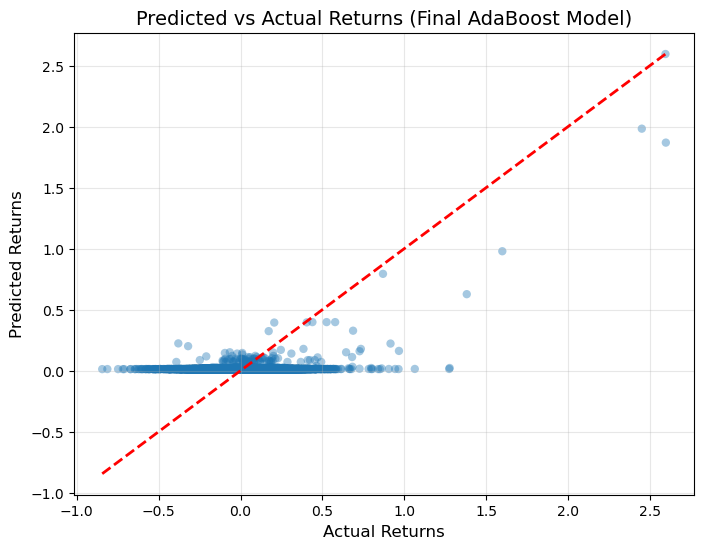

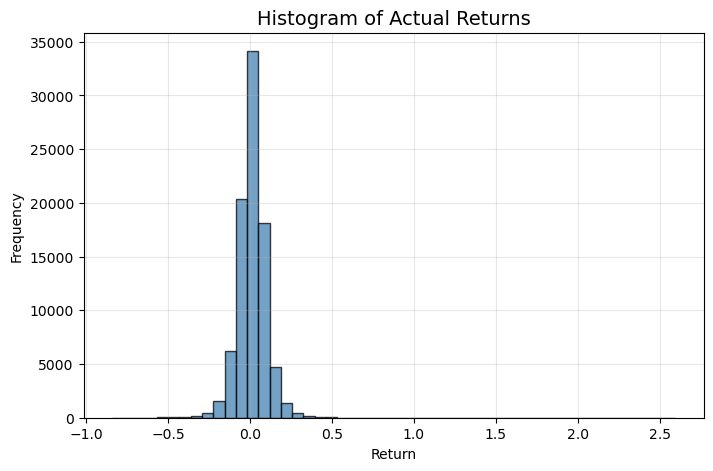

In [109]:
# ================================================================
# PREDICTIONS & DIAGNOSTIC PLOTS FOR FINAL MODEL
# ================================================================
import matplotlib.pyplot as plt
import numpy as np

# 1) Make predictions on the FULL dataset
y_pred = ada_final_full.predict(X)

# =============================
# PLOT 1 — Predicted vs Actual
# =============================
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.4, edgecolors='none')
plt.xlabel("Actual Returns", fontsize=12)
plt.ylabel("Predicted Returns", fontsize=12)
plt.title("Predicted vs Actual Returns (Final AdaBoost Model)", fontsize=14)

# Add y = x diagonal line
lims = [
    min(min(y), min(y_pred)),
    max(max(y), max(y_pred))
]
plt.plot(lims, lims, 'r--', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

# =============================
# PLOT 2 — Histogram of Actual Returns
# =============================
plt.figure(figsize=(8, 5))
plt.hist(y, bins=50, alpha=0.75, color='steelblue', edgecolor='black')
plt.title("Histogram of Actual Returns", fontsize=14)
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

In [111]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# SHAP ANALYSIS FOR FINAL ADA BOOST MODEL (MODEL-AGNOSTIC)
# ============================================================

# 0) Make sure JS is initialized (for Jupyter)
shap.initjs()

# 1) Sample from X to speed up SHAP (AdaBoost + Kernel methods can be slow)
X_shap = X.sample(n=min(2000, len(X)), random_state=42).copy()

# 2) Background sample for the explainer (used as "baseline")
background = X.sample(n=min(200, len(X)), random_state=0).copy()

# 3) Build generic SHAP explainer for AdaBoostRegressor
#    We pass the prediction function and a background dataset.
explainer = shap.Explainer(ada_final_full.predict, background)

# 4) Compute SHAP values for the sampled data
shap_values = explainer(X_shap)   # shap_values is a shap.Explanation object

# 5) Compute mean |SHAP| per feature = global importance
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

shap_importance = pd.DataFrame({
    "feature": X_shap.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

print("===== SHAP FEATURE IMPORTANCE (MEAN |SHAP|) =====")
print(shap_importance)




PermutationExplainer explainer: 2001it [05:52,  5.52it/s]                          

===== SHAP FEATURE IMPORTANCE (MEAN |SHAP|) =====
            feature  mean_abs_shap
7     ma50_slope_l1   2.172081e-04
9       log_mcap_l1   1.383588e-04
12            de_l2   7.797037e-05
11           roe_l2   4.664172e-05
8    ma200_slope_l1   4.299403e-05
6          vol60_l1   2.829233e-05
10          beta_l1   1.961756e-05
14           npm_l2   1.058446e-05
3         dist50_l1   9.631584e-06
5          vol30_l1   7.175452e-06
16            bp_l2   3.706007e-06
13     op_margin_l2   2.285145e-06
2         mom_6m_l1   2.583519e-07
4        dist200_l1   4.287186e-08
15    earn_yield_l2   9.716621e-09
0         mom_1m_l1   0.000000e+00
1         mom_3m_l1   0.000000e+00
17  revps_growth_l2   0.000000e+00


/var/folders/b6/7cjwm51j5zngrjc7t5ck5wz80000gn/T/ipykernel_38575/2954383325.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


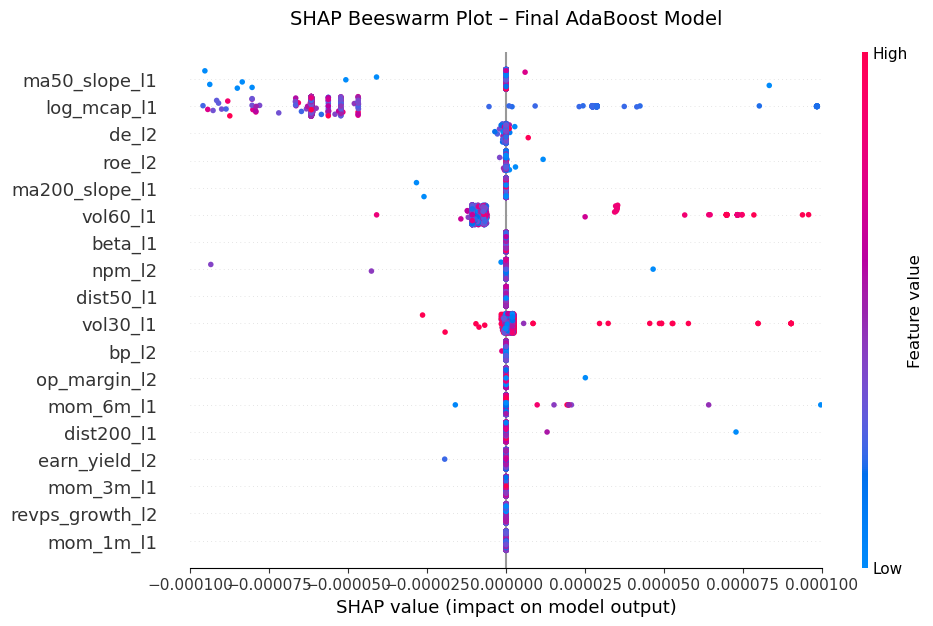

In [127]:
# 6) Beeswarm plot of SHAP values
#    shap.summary_plot works directly with the Explanation object

# (optional) slightly larger default font
plt.rcParams.update({"font.size": 10})

shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="dot",     # beeswarm style
    plot_size=(10, 6),   # width, height in inches – make it larger
    max_display=20,      # top 20 features (default, can change if you want)
    show=False           # so we can adjust layout before displaying
)

plt.title("SHAP Beeswarm Plot – Final AdaBoost Model", fontsize=14, pad=20)
plt.xlim(-0.0001, 0.0001)
plt.show()



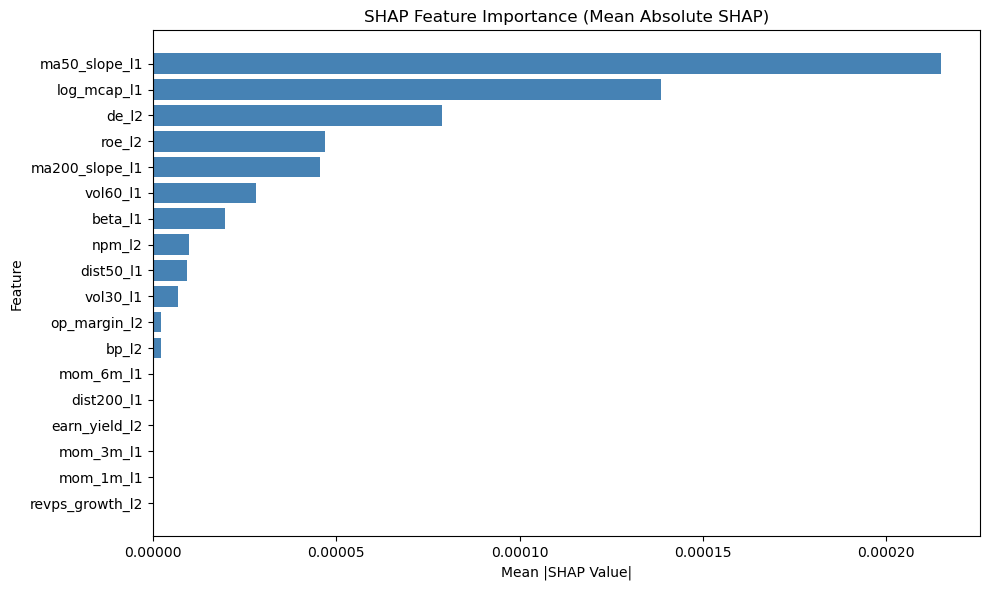

In [106]:
import matplotlib.pyplot as plt

# Sort first (highest at top)
shap_bar = shap_importance.sort_values("mean_abs_shap", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(shap_bar["feature"], shap_bar["mean_abs_shap"], color="steelblue")
plt.xlabel("Mean |SHAP Value|")
plt.ylabel("Feature")
plt.title("SHAP Feature Importance (Mean Absolute SHAP)")
plt.tight_layout()
plt.show()


In [107]:
print("\n===== ALL FEATURE NAMES USED IN MODEL =====")
for f in X.columns:
    print(f)
    
print("\nTotal features:", len(X.columns))



===== ALL FEATURE NAMES USED IN MODEL =====
mom_1m_l1
mom_3m_l1
mom_6m_l1
dist50_l1
dist200_l1
vol30_l1
vol60_l1
ma50_slope_l1
ma200_slope_l1
log_mcap_l1
beta_l1
roe_l2
de_l2
op_margin_l2
npm_l2
earn_yield_l2
bp_l2
revps_growth_l2

Total features: 18
